In [1]:
##  TO-DO

# 1. Plot matching efficiencies by jet/tag category
# 2. Make BDT variable output automatic by key --> eliminate chance of user error

In [2]:
import uproot, uproot_methods
import uproot_methods.classes.TLorentzVector as TLorentzVector
import matplotlib.pyplot as plt
import numpy as np
import itertools
import csv
import copy

t = 0.5  # transparency of plots

testRun = False
dR_cut_quarkToJet = 0.40
mass_higgs = 125.0 #GeV
width_higgs = 15.0 #GeV, reco width
minJetPt = 20.0 #GeV
maxJetAbsEta = 2.5

In [3]:
delphes_hh= uproot.open('../../../MG5_aMC_v2_6_1/ppToHHto4b_14TeV/Events/run_02_decayed_1/tag_1_delphes_events.root')['Delphes']
#b_particles = uproot.tree.TBranchMethods.array(delphes_hh['Particle'])
l_genPID         = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.PID']).tolist()
l_genStatus      = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.Status']).tolist()
l_genPt          = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.PT']).tolist()
l_genEta         = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.Eta']).tolist()
l_genPhi         = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.Phi']).tolist()
l_genMass        = uproot.tree.TBranchMethods.array(delphes_hh['Particle']['Particle.Mass']).tolist()
l_jetPt          = uproot.tree.TBranchMethods.array(delphes_hh['Jet']['Jet.PT']).tolist()
l_jetEta         = uproot.tree.TBranchMethods.array(delphes_hh['Jet']['Jet.Eta']).tolist()
l_jetPhi         = uproot.tree.TBranchMethods.array(delphes_hh['Jet']['Jet.Phi']).tolist()
l_jetMass        = uproot.tree.TBranchMethods.array(delphes_hh['Jet']['Jet.Mass']).tolist()
l_jetBTag        = uproot.tree.TBranchMethods.array(delphes_hh['Jet']['Jet.BTag']).tolist()
l_missingET_met  = uproot.tree.TBranchMethods.array(delphes_hh['MissingET']['MissingET.MET']).tolist()
l_missingET_phi  = uproot.tree.TBranchMethods.array(delphes_hh['MissingET']['MissingET.Phi']).tolist()
l_scalarHT       = uproot.tree.TBranchMethods.array(delphes_hh['ScalarHT']['ScalarHT.HT']).tolist()


In [4]:
##############################################################
##                FUNCTIONS FOR PLOTTING                    ##
##############################################################

def plotOneHistogram(_arr, _nPlot, _title, _xtitle, _xMin, _xMax, _nBins):
    #mean_arr = np.mean(arr)
    #stdev_arr = np.std(arr)
    #nEntries_arr = len(arr)

    #s1 = "Higgs Mass Reconstructed from 4 b-tagged jets:\n" \
    #     "entries = {}, mean = {:.4F}, std dev = {:.4F}".format(nEntries_arr, mean_arr, stdev_arr)

    plt.figure(_nPlot)
    plt.title(_title)
    plt.xlabel(_xtitle)
    _bins = np.linspace(_xMin, _xMax, _nBins)
    plt.hist(_arr, _bins, alpha=t)
    #plt.legend(loc='upper right')
    #plt.text(10, 10, s1)
    plt.show()


    
def compareManyHistograms(_dict, _labels, _nPlot, _title, _xtitle, _xMin, _xMax, _nBins, _normed=False):
    #_mean_arrAll     = np.mean(_arrAll)
    #_stdev_arrAll    = np.std(_arrAll)
    #_nEntries_arrAll = len(_arrAll)
    #s1 = _xtitle + ':Entries = {0}, mean = {1:4F}, std dev = {2:4f}\n'.format(_nEntries_arrAll, _mean_arrAll, _stdev_arrAll)
       
    if len(_dict.keys()) < len(_labels):
        print ("!!! Unequal number of arrays and labels. Learn to count better.")
        return 0
    
    plt.figure(_nPlot)
    if _normed:
        plt.title(_title + ' (Normalized)')
    else:
        plt.title(_title)
    plt.xlabel(_xtitle)
    _bins = np.linspace(_xMin, _xMax, _nBins)
   
    for iLabel in _labels:
        plt.hist(_dict[iLabel], _bins, alpha=t, normed=_normed, label= iLabel+' Events')
    plt.legend(loc='upper right')
    #plt.text(.1, .1, s1)
    
    # store figure copy for later saving
    fig = plt.gcf()
    
    # draw interactively
    plt.show()
    
    # save an image files
    _scope    = _title.split(' ')[0].lower()
    _variable = _xtitle.lstrip('Jet Pair').replace(' ','').replace('[GeV]','')
    _allLabels = ''.join(_labels)
    _filename  = _scope + '_' + pairingAlgorithm + '_' + _allLabels + '_' + _variable
    if _normed:
        _filename = _filename + '_norm'
    fig.savefig( _filename+'.png' )

In [22]:
##############################################################
##                FUNCTIONS FOR INDEXING                    ##
##############################################################

def returnListOfTruthBQuarkIndicesByDaughters(_D1, _D2, _PID):
    _bQuarkIndices = []
    
    for iParticle in range(0, len(_D1)):
         if _PID[iParticle]==25:
            _daughter1 = _D1[iParticle]
            _daughter2 = _D2[iParticle]
            _daughter1_PID = _PID[daughter1]
            _daughter2_PID = _PID[daughter2]
            #print('Event ',iEvt,'has higgs at position',iParticle,'with daughter1 (',daughter1,
            #    ') of PID',daughter1_PID,'and daughter2 (',daughter2,') of PID',daughter2_PID)
            if abs(_daughter1_PID) == 5 and abs(_daughter2_PID)==5:
                _bQuarkIndices.append(_daughter1)
                _bQuarkIndices.append(_daughter2)
    
    return _bQuarkIndices


def returnListOfTruthBQuarkIndicesByStatus(_status):
    _bQuarkIndices = []

    for iParticle in range(0, len(_status)):
        if _status[iParticle]==23:
            _bQuarkIndices.append(iParticle)

    return _bQuarkIndices

def returnNumberAndListOfJetIndicesPassingCuts(_jetPt, _jetEta, _jetBTag, _cut_jetPt, _cut_jetEta, _requireTags=False, _ptOrdered=False):
    _jetIndices = []
    _nJets = 0
    _nBTags = 0

    for iJet in range(0, len(_jetPt)): 
        if _jetPt[iJet] > _cut_jetPt and abs(_jetEta[iJet]) < _cut_jetEta:
            _nJets += 1
            if not _requireTags:
                _jetIndices.append(iJet)
                
            if _jetBTag[iJet] == 1:
                _nBTags += 1
                if _requireTags and len(_jetIndices)<4:
                    if _ptOrdered:
                        _added = False
                        for index in range(0, len(_jetIndices)):
                            if _jetPt[iJet] > _jetPt[index] and _added==False:
                                _jetIndices.insert(index, iJet)
                                _added = True
                            
                        if _added == False:
                            _jetIndices.append(iJet)
                    else:
                        _jetIndices.append(iJet)
        
        #if len(_jetIndices)==4:
        #    break
            
    #print (_jetIndices)
    print (_nJets, _nBTags, len(_jetIndices), [_jetPt[g] for g in _jetIndices])
    
    return _nJets, _nBTags, _jetIndices

def getDictOfQuarksMatchedToJets(_quarkIndices, _jetIndices, _genPt, _genEta, _genPhi, _genMass, _jetPt, _jetEta, _jetPhi, _jetMass): 
    _matchedQuarksToJets = {}
    _dictOfJetVectors = {}
    _dictOfQuarkVectors = {}
    
    for iQuark in _quarkIndices:
        tlv_quark = TLorentzVector.PtEtaPhiMassLorentzVector( _genPt[iQuark], _genEta[iQuark], _genPhi[iQuark], _genMass[iQuark])
        if iQuark not in _dictOfQuarkVectors.keys():
            _dictOfQuarkVectors[iQuark] = tlv_quark
            
        for iJet in _jetIndices:
            tlv_jet = TLorentzVector.PtEtaPhiMassLorentzVector( _jetPt[iJet], _jetEta[iJet], _jetPhi[iJet], _jetMass[iJet])
            if iJet not in _dictOfJetVectors.keys():
                _dictOfJetVectors[iJet] = tlv_jet
        
            # skip jets
            if tlv_quark.delta_r( tlv_jet) > dR_cut_quarkToJet:
                continue

            if iQuark not in _matchedQuarksToJets.keys():
                _matchedQuarksToJets.update({iQuark:[iJet]})
            else:
                _matchedQuarksToJets[iQuark].append(iJet)

    return _matchedQuarksToJets, _dictOfJetVectors, _dictOfQuarkVectors

In [23]:
##############################################################
##                FUNCTIONS FOR MATCHING                    ##
##############################################################

def getHarmonicMeanDeltaR(_jetPairTuple, _jetVectorDict):

    # get deltaR between each pair
    _deltaR_pair1 = _jetVectorDict[_jetPairTuple[0]].delta_r(_jetVectorDict[_jetPairTuple[1]])
    _deltaR_pair2 = _jetVectorDict[_jetPairTuple[2]].delta_r(_jetVectorDict[_jetPairTuple[3]])
    if _deltaR_pair1 == 0 or _deltaR_pair2==0:
        print('pair1',_deltaR_pair1, _jetPairTuple[0], _jetPairTuple[1], _jetVectorDict[_jetPairTuple[0]].pt, _jetVectorDict[_jetPairTuple[1]].pt)
        print('pair2',_deltaR_pair2, _jetPairTuple[2], _jetPairTuple[3], _jetVectorDict[_jetPairTuple[2]].pt, _jetVectorDict[_jetPairTuple[3]].pt)
    
    # calculate the harmonic mean
    _meanDeltaR = np.reciprocal( ( np.reciprocal(_deltaR_pair1) + np.reciprocal(_deltaR_pair2) ) / 2 )
    #print(_jetPairTuple, _meanDeltaR, _deltaR_pair1, _deltaR_pair2)
    
    return _meanDeltaR
    
def getEqualDeltaR(_jetPairTuple, _jetVectorDict):

    # get deltaR between each pair
    _deltaR_pair1 = _jetVectorDict[_jetPairTuple[0]].delta_r(_jetVectorDict[_jetPairTuple[1]])
    _deltaR_pair2 = _jetVectorDict[_jetPairTuple[2]].delta_r(_jetVectorDict[_jetPairTuple[3]])
    
    # calculate the harmonic mean
    _diffDeltaR = abs( _deltaR_pair1 - _deltaR_pair2 )
    #print(_jetPairTuple, _meanDeltaR, _deltaR_pair1, _deltaR_pair2)
    
    return _diffDeltaR

def getHiggsMassDifference(_jetPairTuple, _jetVectorDict):

    # get deltaR between each pair
    _mass_pair1 = ( _jetVectorDict[_jetPairTuple[0]] + _jetVectorDict[_jetPairTuple[1]] ).mass 
    _mass_pair2 = ( _jetVectorDict[_jetPairTuple[2]] + _jetVectorDict[_jetPairTuple[3]] ).mass 
    
    # calculate the quadrature sum of higgs mass diff and divide by reco higgs width
    _quadratureMassDifference = np.sqrt( ( (_mass_pair1 - mass_higgs) / width_higgs )**2 + ( (_mass_pair2 - mass_higgs) / width_higgs )**2 )
    #print(_jetPairTuple, _quadratureMassDifference, _massDiff_pair1, _massDiff_pair2)
    
    return _quadratureMassDifference


def getDijetMassDifference(_jetPairTuple, _jetVectorDict):

    # get masses for each pair
    _mass_pair1 = ( _jetVectorDict[_jetPairTuple[0]] + _jetVectorDict[_jetPairTuple[1]] ).mass 
    _mass_pair2 = ( _jetVectorDict[_jetPairTuple[2]] + _jetVectorDict[_jetPairTuple[3]] ).mass 
    
    # calculate the direct difference of reco dijet masses
    _dijetMassDifference = abs(_mass_pair1 - _mass_pair2)
    #print(_jetPairTuple, _quadratureMassDifference, _massDiff_pair1, _massDiff_pair2)
    
    return _dijetMassDifference


def getBothDijetMasses(_jetPairTuple, _jetVectorDict):

    # get masses of each pair
    _mass_pair1 = ( _jetVectorDict[_jetPairTuple[0]] + _jetVectorDict[_jetPairTuple[1]] ).mass 
    _mass_pair2 = ( _jetVectorDict[_jetPairTuple[2]] + _jetVectorDict[_jetPairTuple[3]] ).mass 
    
    # make a list of the two masses
    _bothDijetMasses = [_mass_pair1, _mass_pair2 ]
    
    return _bothDijetMasses


def returnMetric(_pairingAlgorithm, _sortedTuple, _jetVectorDict):
    # calculate metric depending on chosen algorithm
    _metric = []
    
    if _pairingAlgorithm == "minHarmonicMeanDeltaR":
        _metric = getHarmonicMeanDeltaR(_sortedTuple, _jetVectorDict)
    elif _pairingAlgorithm == "closestDijetMassesToHiggs":
        _metric = getHiggsMassDifference(_sortedTuple, _jetVectorDict)
    elif _pairingAlgorithm == "equalDijetMass":
        _metric = getDijetMassDifference(_sortedTuple, _jetVectorDict)
    elif _pairingAlgorithm == "equalDeltaR":
        _metric = getEqualDeltaR(_sortedTuple, _jetVectorDict)
    elif _pairingAlgorithm == "dijetMasses":
        _metric = getBothDijetMasses(_sortedTuple, _jetVectorDict)
    
    _metric = _metric if type(_metric)==list else [_metric]
    return _metric
                
    
def selectPairsViaMatchingAlgorithm(_plottingData, _jetVectorDict, _pairingAlgorithm):

    # make list of pairs from [n choose 2] where n is number of jets
    _jetPairs = list(itertools.combinations(_jetVectorDict.keys(),2))
    _doubleJetPairs = {}
    
    # loop over jet pairs
    for pair in _jetPairs:
        # make list of leftover pairs that do not contain either jet in starting pair
        _notPair = [x for x in list(_jetPairs) if pair[0] not in x and pair[1] not in x]
        for pairOption in _notPair:
            _sortedPairing = sorted([sorted(x) for x in [pair, pairOption]])
            _sortedTuple = tuple(_sortedPairing[0]+_sortedPairing[1])

            # add double pairing to dictionary if not already present. sorting removes positional ambiguity
            if _sortedTuple not in _doubleJetPairs.keys():
                _metric = returnMetric(_pairingAlgorithm, _sortedTuple, _jetVectorDict)
              
                _doubleJetPairs[_sortedTuple] = _metric
                _plottingData[_pairingAlgorithm]['All'].extend( _metric )
                if thisEventIsMatchable:
                    _plottingData[_pairingAlgorithm]['Matchable'].extend( _metric )
                    
    # sort output dict and find minimal value
    _bestPairing = sorted(_doubleJetPairs.items(), key=lambda _pairingAndMetric: _pairingAndMetric[1][0])[0]
    _plottingData[_pairingAlgorithm]['Best'].extend( _bestPairing[1] )   
    if thisEventIsMatchable:
        # fill algorithm-selected lists for plotting
        _plottingData[_pairingAlgorithm]['Best+Matchable'].extend( _bestPairing[1] )
        
            
    return (_bestPairing[0][0], _bestPairing[0][1]), (_bestPairing[0][2] , _bestPairing[0][3]), _bestPairing[1][0]


def fillVariablePlotsForCorrectPairing(iEvt, _plottingData, _matchedJetVector, _pairingAlgorithm):
    _correctTuple = (0, 1, 2, 3)
    _metric = returnMetric(_pairingAlgorithm, _correctTuple, _matchedJetVector)
    _plottingData[_pairingAlgorithm]['Correct'].extend( _metric )
    if _metric[0]==0:
        print (iEvt)
        
    return
    


In [24]:
##############################################################
##                FUNCTIONS FOR EFFICIENCY                  ##
##############################################################

def returnJetTagLabels(_nJets, _nBTags):

    # every event is inclusive
    _categoryLabels = ['Incl']    
    
    # split into tag-inclusive bins, 6j means >= 6 jets
    if _nJets == 4:
        _categoryLabels.append('4jIncl')
    elif _nJets == 5:
        _categoryLabels.append('5jIncl')
    elif _nJets == 6:
        _categoryLabels.append('6jIncl')
    elif _nJets >= 7:
        _categoryLabels.append('7jIncl')
        
    # split into tag bins, 4b means >= 4 tags
    _jetLabel = str(_nJets) if _nJets <= 7 else str(7)
    _tagLabel = str(_nBTags) if _nBTags <= 7 else str(7)
    _categoryLabels.append( _jetLabel+'j'+_tagLabel+'b' )
    
    return _categoryLabels


def countEvents(_evtCounterDict, _cutflowBin, _nJets, _nBTags):

    _categoryLabels = returnJetTagLabels(_nJets, _nBTags)
    for iAlgorithm in _evtCounterDict:
        for iLabel in _categoryLabels:
            _evtCounterDict[iAlgorithm][iLabel][_cutflowBin] += 1
        
    
def evaluatePairingEfficiency(_evtCounterDict, _quarkToJetDict, _jetPair1, _jetPair2, _nJets, _nBTags, _algorithm):
                
        # Organize quark-to-jet pairs from truth into directly comparable tuples
        _indexList = list( _quarkToJetDict.values() ) 
        _orderedIndexTuple = sorted( ( tuple(sorted( (_indexList[0][0], _indexList[1][0]) )) , tuple(sorted( (_indexList[2][0], _indexList[3][0]) )) ) )
        _indexPair1 = _orderedIndexTuple[0]
        _indexPair2 = _orderedIndexTuple[1]
        
        # Do some global counting
        _categoryLabels = returnJetTagLabels(_nJets, _nBTags)
        for iLabel in _categoryLabels:
            if _jetPair1 == _indexPair1 and _jetPair2 == _indexPair2:
                _evtCounterDict[_algorithm][iLabel]['Fully Matched'] += 1
         
            if _jetPair1 == _indexPair1 or _jetPair2 == _indexPair2:
                _evtCounterDict[_algorithm][iLabel]['>= 1 Pair Matched'] += 1
        
        return 
    
def printEventCounterInfo( _evtCounterDict, _catTag ):

    print('====================================================')
    print("!!!! Event Counter Info For "+_catTag)
    print("Number of Events:", _evtCounterDict[_catTag]['All'])
    print("Number of Events with 4 truth-matchable jets:", _evtCounterDict[_catTag]['Matchable'])
    print("Number of Events Fully Matched:", _evtCounterDict[_catTag]['Fully Matched'])
    print("Number of Events with >= 1 Pair Matched:", _evtCounterDict[_catTag]['>= 1 Pair Matched'])
    if _evtCounterDict[_catTag]['Matchable'] > 0:
        print('Efficiency For Fully Matched: ',round( 100*float(_evtCounterDict[_catTag]['Fully Matched']/_evtCounterDict[_catTag]['Matchable']) , 2),'%')
        print('Efficiency For >= 1 Pair Matched: ',round( 100*float(_evtCounterDict[_catTag]['>= 1 Pair Matched']/_evtCounterDict[_catTag]['Matchable']) , 2),'%')
 
    return


def listOfEfficiencesForAlgorithm(_evtCounterDict):
    _fullyMatchedDict = {}
    _onePairMatchedDict = {}
    
    for _iAlgorithm in _evtCounterDict:
        _fullyMatchedDict[_iAlgorithm] = {}
        _onePairMatchedDict[_iAlgorithm] = {}
        for _iCategory in _evtCounterDict[_iAlgorithm]:
            if _evtCounterDict[_iAlgorithm][_iCategory]['Matchable'] > 0:
                _fullyMatchedEff  = round( 100*float(_evtCounterDict[_iAlgorithm][_iCategory]['Fully Matched']/_evtCounterDict[_iAlgorithm][_iCategory]['Matchable']), 2)
                _onePairMatchedEff = round( 100*float(_evtCounterDict[_iAlgorithm][_iCategory]['>= 1 Pair Matched']/_evtCounterDict[_iAlgorithm][_iCategory]['Matchable']), 2)
                _fullyMatchedDict[_iAlgorithm][_iCategory] = _fullyMatchedEff
                _onePairMatchedDict[_iAlgorithm][_iCategory] = _onePairMatchedEff
                #print(_algorithm, _iCategory)
                #print('Efficiency For Fully Matched: ', _fullyMatchedEff,'%')
                #print('Efficiency For >= 1 Pair Matched: ', _onePairMatchedEff,'%')
 
    return _fullyMatchedDict, _onePairMatchedDict

    

In [25]:
##############################################################
##           FUNCTIONS FOR CALCULATING BDT VARS             ##
##############################################################

def calculateVariablesForBDT( _jetPair1, _jetPair2, _jetVectorDict, _nJets, _nBTags, _met, _met_phi, _scalarHT, _addLowLevel = False):
    _variableList = []
    
    _tlv_h1_j0 = _jetVectorDict[ _jetPair1[0] ]
    _tlv_h1_j1 = _jetVectorDict[ _jetPair1[1] ]
    _tlv_h2_j2 = _jetVectorDict[ _jetPair2[0] ]
    _tlv_h2_j3 = _jetVectorDict[ _jetPair2[1] ]
    _tlv_h1 = _tlv_h1_j0 + _tlv_h1_j1
    _tlv_h2 = _tlv_h2_j2 + _tlv_h2_j3

    """print('====================================================')
    print ("hh mass: ", (_tlv_h1 + _tlv_h2).mass)
    print ("h1 mass: ", _tlv_h1.mass)
    print ("h2 mass: ", _tlv_h2.mass)
    print ("hh pt: ", (_tlv_h1 + _tlv_h2).pt)
    print ("h1 pt: ", _tlv_h1.pt)
    print ("h2 pt: ", _tlv_h2.pt)
    print ("dR(h1, h2): ",  _tlv_p1.delta_r( _tlv_p2 ))
    print ("for h1, dR(j0, j1): ",  _tlv_h1_j0.delta_r( _tlv_h1_j1 ))
    print ("for h2, dR(j2, j3): ",  _tlv_h2_j2.delta_r( _tlv_h2_j3 ))
    print ("for h1, dPhi(j0, j1): ",  _tlv_h1_j0.delta_phi( _tlv_h1_j1 ))
    print ("for h2, dPhi(j2, j3): ",  _tlv_h2_j2.delta_phi( _tlv_h2_j3 ))
    print ("MET, met_phi: ", _met[0], _met_phi[0])
    print ("Scalar HT: ", _scalarHT[0])
    print ("nJets, nBTags: ", _nJets, _nBTags)
    """
    _nDigits = 3
    
    _variableList = [ (_tlv_h1 + _tlv_h2).mass, _tlv_h1.mass, _tlv_h2.mass,
                     (_tlv_h1 + _tlv_h2).pt, _tlv_h1.pt, _tlv_h2.pt,
                    _tlv_h1.delta_r(_tlv_h2), 
                    _tlv_h1_j0.delta_r(_tlv_h1_j1), _tlv_h2_j2.delta_r(_tlv_h2_j3), 
                    _tlv_h1_j0.delta_phi(_tlv_h1_j1), _tlv_h2_j2.delta_phi(_tlv_h2_j3), 
                    _met[0], _met_phi[0], _scalarHT[0], 
                    _nJets, _nBTags,
                    _tlv_h1_j0.pt, _tlv_h1_j1.pt, _tlv_h2_j2.pt, _tlv_h2_j3.pt, 
                    _tlv_h1_j0.eta, _tlv_h1_j1.eta, _tlv_h2_j2.eta, _tlv_h2_j3.eta
                    ]
    
    return _variableList

In [26]:
outputDataForLearning = []
outputVariableNames = ['hh_mass', 'h1_mass', 'h2_mass', 'hh_pt', 'h1_pt', 'h2_pt', 'deltaR(h1, h2)', 'deltaR(h1 jets)', 'deltaR(h2 jets)', 'deltaPhi(h1 jets)', 'deltaPhi(h2 jets)', 'met', 'met_phi', 'scalarHT', 'nJets', 'nBTags', "jet1_pt", "jet2_pt", "jet3_pt", "jet4_pt", "jet1_eta", "jet2_eta", "jet3_eta", "jet4_eta"]

##  Without quality cuts on pairing algorithms:
##  closestDijetMassesToHiggs   gets both pairs correct 46.7% of the time
##  minHarmonicMeanDeltaR       gets both pairs correct 34.8% of the time
##  equalDeltaR                 gets both pairs correct 18.9% of the time
##  equalDijetMass              gets both pairs correct 17.2% of the time
##  dijetMasses                 IS NOT A MINIMIAZION METRIC

saveAlgorithm = 'minHarmonicMeanDeltaR' # options include: 1) minHarmonicMeanDeltaR, 2) higgsMassDifference, 3) dijetMassDifference, 4) equal Delta R
pairingAlgorithms = ['minHarmonicMeanDeltaR', 'closestDijetMassesToHiggs', 'equalDijetMass', 'equalDeltaR', 'dijetMasses']
variableCategoryDict = {'All':[], 'Matchable':[], 'Best':[], 'Best+Matchable':[], 'Correct':[]}

cutflowDict = { 'All':0, 'Matchable':0, 'Fully Matched':0, '>= 1 Pair Matched':0}
jetTagCategories = ['Incl',
                    '4jIncl', '4j0b', '4j1b', '4j2b', '4j3b', '4j4b', 
                    '5jIncl', '5j0b', '5j1b', '5j2b', '5j3b', '5j4b', '5j5b', 
                    '6jIncl', '6j0b', '6j1b', '6j2b', '6j3b', '6j4b', '6j5b', '6j6b',
                    '7jIncl', '7j0b', '7j1b', '7j2b', '7j3b', '7j4b', '7j5b', '7j6b', '7j7b']


plottingData = {algorithm:copy.deepcopy(variableCategoryDict) for algorithm in pairingAlgorithms}
eventCounterDict = { algorithm:{category:copy.deepcopy(cutflowDict) for category in jetTagCategories} for algorithm in pairingAlgorithms}
nBTagsPerEvent  = []
nJetsPerEvent   = []
thisEventIsMatchable = False
thisEventWasCorrectlyMatched = False


for iEvt in range(0,delphes_hh.fEntries):
    # *** 0. Kick-out condition for testing
    if iEvt > 40 and testRun is True:
        continue
    if iEvt%2000==0:
        print("Analyzing event number",iEvt)
    
    # *** 1. Get truth information
    indicesByStatus    = returnListOfTruthBQuarkIndicesByStatus(l_genStatus[iEvt])   
    if len(indicesByStatus) != 4:
        print ("!!! WARNING: iEvt = {0} did not find 4 truth b-quarks. Only found {1} !!!".format(iEvt, len(indicesByStatus)))
        continue
        
    # *** 2. Get jet reco information
    nJets, nBTags, jetIndices = returnNumberAndListOfJetIndicesPassingCuts(l_jetPt[iEvt], l_jetEta[iEvt], l_jetBTag[iEvt], minJetPt, maxJetAbsEta, _requireTags=True, _ptOrdered=True)
    nJetsPerEvent.append(nJets)
    nBTagsPerEvent.append(nBTags)

    #if nJets < 4: continue 
    if len(jetIndices) < 4: continue 
    countEvents( eventCounterDict, 'All', nJets, nBTags )
    
    # *** 3. Do some quark-to-jet truth matching
    thisEventIsMatchable = False
    thisEventWasCorrectlyMatched = False
    matchedQuarksToJets, jetVectorDict, quarkVectorDict = getDictOfQuarksMatchedToJets(indicesByStatus, jetIndices, l_genPt[iEvt], l_genEta[iEvt], l_genPhi[iEvt], l_genMass[iEvt], l_jetPt[iEvt], l_jetEta[iEvt], l_jetPhi[iEvt], l_jetMass[iEvt])
    # Check if a) all matches have one and only match between quark and jet, b) four jets are matched, c) 4 unique reconstructed jets are selected
    jetIndexList = [recoIndex[0] for recoIndex in matchedQuarksToJets.values()]
    if all(len(matchedJets) == 1 for matchedJets in matchedQuarksToJets.values()) and len(matchedQuarksToJets)==4  and (len(set(jetIndexList)) == len(jetIndexList)):     
        thisEventIsMatchable = True
        countEvents( eventCounterDict, 'Matchable', nJets, nBTags )
        
    # *** 4. Evaluate all pairing algorithms
    for iAlgorithm in pairingAlgorithms:
        # ** A. Fill algorithm metric for correct pairing (regardless if chosen by metric)
        if thisEventIsMatchable == True:
            fillVariablePlotsForCorrectPairing(iEvt, plottingData, [jetVectorDict[matchedJet[0]] for matchedJet in matchedQuarksToJets.values()], iAlgorithm)

        # ** B. Pick two jet pairs based on algorithm
        jetPair1, jetPair2, pairingMetric = selectPairsViaMatchingAlgorithm(plottingData, jetVectorDict, iAlgorithm)
    
        # ** C. Evaluate efficiency of pairing algorithm
        if thisEventIsMatchable:
            evaluatePairingEfficiency(eventCounterDict, matchedQuarksToJets, jetPair1, jetPair2, nJets, nBTags, iAlgorithm)
    
        # ** D. Calculate and save variables for BDT training for single algorithm set by saveAlgorithm
        if iAlgorithm == saveAlgorithm: 
            variablesForBDT = calculateVariablesForBDT(jetPair1, jetPair2, jetVectorDict, nJets, nBTags, 
                                                        l_missingET_met[iEvt], l_missingET_phi[iEvt], l_scalarHT[iEvt])
            outputDataForLearning.append(variablesForBDT)

    
# *** 5. Store output data in .csv for later usage
csvFile = open('dihiggsOutputDataForLearning.csv', mode='w')
writer = csv.DictWriter(csvFile, fieldnames=outputVariableNames)
writer.writeheader()
for eventData in outputDataForLearning:
    csvLineDict = {}
    # format csv line using names of variables
    for iVariable in range(0, len(outputVariableNames)):
        csvLineDict[ outputVariableNames[iVariable] ] = eventData[iVariable]
    # write line to .csv
    writer.writerow( csvLineDict )
csvFile.close()


# *** 8. Print event counter info 
printEventCounterInfo(eventCounterDict['closestDijetMassesToHiggs'], 'Incl')
printEventCounterInfo(eventCounterDict['closestDijetMassesToHiggs'], '4jIncl')
printEventCounterInfo(eventCounterDict['closestDijetMassesToHiggs'], '4j4b')
#print (eventCounterDict)
#printEventCounterInfo(eventCounterDict_4b, '>= 4 b-Tags')

Analyzing event number 0
6 1 1 [44.71555709838867]
4 4 4 [111.57537078857422, 102.03894805908203, 50.468727111816406, 37.141082763671875]
7 2 2 [146.98709106445312, 54.09135437011719]
7 3 3 [166.31454467773438, 67.89440155029297, 57.711631774902344]
5 2 2 [194.85031127929688, 44.202022552490234]
8 3 3 [161.8031005859375, 141.8668670654297, 95.45589447021484]
3 3 3 [73.54926300048828, 66.55550384521484, 32.4418830871582]
4 3 3 [147.4183807373047, 90.86539459228516, 43.071258544921875]
4 3 3 [165.35794067382812, 139.8646240234375, 116.91761016845703]
3 2 2 [34.075077056884766, 30.33355140686035]
4 3 3 [103.05419921875, 30.144790649414062, 26.07699966430664]
3 3 3 [168.98291015625, 152.94505310058594, 65.32394409179688]
4 2 2 [157.42385864257812, 104.53518676757812]
2 2 2 [49.78577423095703, 49.54008865356445]
6 5 4 [112.84707641601562, 78.33474731445312, 73.40586853027344, 45.613136291503906]
4 2 2 [87.85885620117188, 24.960407257080078]
7 2 2 [265.3943176269531, 55.85122299194336]
4 2 2

4 2 2 [110.2826919555664, 67.08238220214844]
4 2 2 [116.708251953125, 112.3539047241211]
4 2 2 [297.2442626953125, 179.2916717529297]
7 4 4 [399.07244873046875, 150.6551513671875, 120.14527130126953, 53.59931945800781]
6 1 1 [32.250572204589844]
4 2 2 [248.56820678710938, 53.580902099609375]
7 3 3 [251.35678100585938, 65.25233459472656, 25.516435623168945]
4 2 2 [121.60829162597656, 121.18362426757812]
6 3 3 [161.0004119873047, 119.09256744384766, 93.40332794189453]
4 2 2 [74.39035034179688, 35.460567474365234]
5 3 3 [214.91415405273438, 74.8192138671875, 44.74615478515625]
7 4 4 [152.52682495117188, 114.48030090332031, 54.36967468261719, 37.771549224853516]
4 2 2 [102.72772979736328, 29.591276168823242]
8 3 3 [166.33937072753906, 145.91322326660156, 37.515098571777344]
2 1 1 [115.96282958984375]
5 2 2 [133.77496337890625, 35.35916519165039]
4 3 3 [83.01457214355469, 66.1039810180664, 36.4669189453125]
4 2 2 [123.95756530761719, 58.57807922363281]
4 4 4 [105.94945526123047, 88.89947509

4 3 3 [130.50881958007812, 98.53561401367188, 49.165992736816406]
3 3 3 [60.6363410949707, 57.15214157104492, 50.773033142089844]
3 2 2 [145.3562469482422, 122.38382720947266]
4 2 2 [204.0762481689453, 135.29067993164062]
7 3 3 [100.49622344970703, 56.370147705078125, 28.710960388183594]
3 1 1 [117.18890380859375]
5 1 1 [572.511474609375]
7 3 3 [84.22277069091797, 78.20435333251953, 65.34595489501953]
5 4 4 [104.73057556152344, 72.34637451171875, 61.780338287353516, 47.38186264038086]
3 1 1 [93.78465270996094]
3 1 1 [65.8307113647461]
2 2 2 [59.55274200439453, 50.86508560180664]
6 3 3 [81.51931762695312, 78.24459838867188, 74.38641357421875]
7 4 4 [353.7168884277344, 188.86178588867188, 55.035545349121094, 37.1504020690918]
5 2 2 [153.0694122314453, 103.0650405883789]
4 2 2 [104.09973907470703, 60.54546356201172]
3 3 3 [149.4254913330078, 95.36354064941406, 68.94178771972656]
4 2 2 [282.88006591796875, 77.89190673828125]
5 2 2 [277.00433349609375, 82.29334259033203]
6 2 2 [257.73898315

6 3 3 [240.8347625732422, 74.09320068359375, 38.35109329223633]
5 2 2 [267.1738586425781, 46.325016021728516]
4 2 2 [172.70071411132812, 30.972455978393555]
5 1 1 [193.44635009765625]
4 4 4 [197.39993286132812, 181.7869873046875, 146.28793334960938, 28.932296752929688]
4 3 3 [202.03045654296875, 162.1920928955078, 118.5399169921875]
5 3 3 [180.22140502929688, 73.12751770019531, 68.26043701171875]
4 1 1 [229.0962371826172]
4 2 2 [108.75679016113281, 77.79240417480469]
5 4 4 [81.48516845703125, 62.59603500366211, 29.475465774536133, 28.813892364501953]
5 3 3 [129.36502075195312, 91.06244659423828, 57.69551467895508]
6 3 3 [169.1990203857422, 81.78001403808594, 78.00692749023438]
5 2 2 [420.1405944824219, 44.4260368347168]
4 4 4 [107.62593841552734, 107.28970336914062, 82.30473327636719, 66.29427337646484]
3 1 1 [88.4349365234375]
6 3 3 [145.96343994140625, 44.33249282836914, 40.974456787109375]
4 3 3 [118.09651947021484, 85.16357421875, 42.722434997558594]
8 3 3 [282.1294250488281, 78.28

7 3 3 [124.73601531982422, 66.88447570800781, 42.74818801879883]
7 3 3 [124.67996215820312, 123.73585510253906, 109.87845611572266]
8 3 3 [210.66835021972656, 145.56504821777344, 130.3007049560547]
5 3 3 [110.2320327758789, 72.78952026367188, 68.02201843261719]
4 4 4 [69.79337310791016, 68.36334228515625, 41.46341323852539, 36.15689468383789]
5 1 1 [137.85523986816406]
4 1 1 [94.79163360595703]
5 2 2 [187.560546875, 24.32452964782715]
5 0 0 []
3 2 2 [108.90695190429688, 98.69303131103516]
6 2 2 [212.38885498046875, 23.552705764770508]
4 4 4 [118.7302474975586, 107.65614318847656, 40.79866027832031, 37.50123977661133]
5 3 3 [130.04055786132812, 60.220947265625, 38.83258819580078]
5 3 3 [103.28990936279297, 49.88607406616211, 36.54082489013672]
5 4 4 [311.72088623046875, 168.3220977783203, 166.09568786621094, 68.52716064453125]
2 2 2 [108.90330505371094, 107.82733154296875]
5 1 1 [72.37279510498047]
4 2 2 [208.4033966064453, 30.39259147644043]
4 4 4 [141.53736877441406, 96.69200134277344

3 2 2 [62.889984130859375, 45.68381118774414]
4 2 2 [50.614620208740234, 27.796123504638672]
5 1 1 [112.61087799072266]
4 1 1 [99.15955352783203]
5 1 1 [106.82559967041016]
7 4 4 [239.7871856689453, 138.85235595703125, 117.5796890258789, 113.10167694091797]
4 1 1 [82.632080078125]
5 2 2 [213.11187744140625, 150.4291534423828]
5 2 2 [128.586181640625, 111.46687316894531]
8 2 2 [86.1641616821289, 24.23454475402832]
4 3 3 [124.26455688476562, 75.42748260498047, 71.85272979736328]
5 3 3 [78.1454086303711, 71.40087127685547, 25.68121337890625]
5 3 3 [184.72998046875, 159.9094696044922, 35.55221939086914]
4 4 4 [91.04570770263672, 67.73566436767578, 29.961978912353516, 26.361019134521484]
6 4 4 [121.53486633300781, 104.22529602050781, 64.68035125732422, 50.772953033447266]
5 2 2 [113.41034698486328, 66.3038330078125]
4 2 2 [268.30029296875, 87.30616760253906]
5 4 4 [189.5142059326172, 186.9976348876953, 40.35111618041992, 27.199783325195312]
3 1 1 [51.05683898925781]
1 1 1 [78.77690887451172

5 2 2 [210.3053741455078, 59.117855072021484]
2 2 2 [39.10124969482422, 37.44076919555664]
4 3 3 [77.8853530883789, 68.02763366699219, 51.71796798706055]
4 3 3 [122.35298156738281, 116.04299926757812, 44.09123611450195]
3 2 2 [77.88825988769531, 56.08822250366211]
6 3 3 [110.23859405517578, 51.071128845214844, 26.680675506591797]
6 3 3 [125.66295623779297, 80.06400299072266, 51.7719841003418]
4 3 3 [176.54656982421875, 128.95208740234375, 64.8313980102539]
2 1 1 [86.39981842041016]
5 3 3 [153.9069061279297, 66.73307037353516, 38.14120864868164]
5 4 4 [249.68621826171875, 236.50999450683594, 132.88963317871094, 51.766082763671875]
3 3 3 [252.15086364746094, 180.46348571777344, 119.27700805664062]
3 2 2 [215.62875366210938, 163.65090942382812]
5 3 3 [338.1468505859375, 122.46434783935547, 63.53343200683594]
3 3 3 [150.37460327148438, 120.02234649658203, 58.787559509277344]
7 3 3 [103.44085693359375, 66.99510192871094, 29.207172393798828]
6 3 3 [388.91375732421875, 232.3080291748047, 23.5

5 3 3 [79.0430679321289, 74.1377182006836, 58.245243072509766]
4 4 4 [217.7519073486328, 208.3621063232422, 122.41665649414062, 107.4016342163086]
4 2 2 [239.84033203125, 135.634521484375]
4 1 1 [130.19964599609375]
5 2 2 [290.0314025878906, 76.69390869140625]
4 1 1 [91.91740417480469]
9 4 4 [335.216796875, 282.7693176269531, 212.22007751464844, 133.97793579101562]
4 2 2 [98.3831558227539, 95.57050323486328]
3 1 1 [126.01100158691406]
7 1 1 [138.50498962402344]
4 3 3 [184.9728240966797, 109.75306701660156, 94.47942352294922]
4 2 2 [123.10734558105469, 72.1872329711914]
3 3 3 [94.63580322265625, 75.76020812988281, 70.74323272705078]
4 4 4 [144.64674377441406, 57.52963638305664, 40.5614128112793, 32.02776336669922]
6 1 1 [142.4071502685547]
5 1 1 [35.579750061035156]
5 1 1 [22.628673553466797]
6 3 3 [39.78433609008789, 36.76988983154297, 29.336055755615234]
4 2 2 [122.87040710449219, 110.27799224853516]
4 1 1 [137.32980346679688]
4 0 0 []
6 3 3 [84.32568359375, 75.13968658447266, 62.2667

3 2 2 [82.45199584960938, 60.106048583984375]
12 3 3 [189.08168029785156, 79.29905700683594, 63.14903259277344]
4 2 2 [91.32059478759766, 86.6744155883789]
4 0 0 []
5 1 1 [197.0703887939453]
7 3 3 [74.16902160644531, 57.94327163696289, 38.14424514770508]
4 3 3 [144.84307861328125, 117.5016098022461, 48.37134552001953]
3 2 2 [151.98252868652344, 29.67889404296875]
5 2 2 [257.2532043457031, 89.49949645996094]
7 6 4 [259.9798889160156, 125.8388671875, 64.50320434570312, 60.40754699707031]
2 2 2 [137.85934448242188, 63.726097106933594]
3 2 2 [128.68324279785156, 119.9127197265625]
5 4 4 [158.2717742919922, 140.87017822265625, 53.476924896240234, 51.90654373168945]
3 1 1 [148.8415985107422]
4 1 1 [51.57658767700195]
5 4 4 [214.77149963378906, 168.5491485595703, 28.383913040161133, 23.579450607299805]
3 3 3 [134.14633178710938, 127.369384765625, 28.889406204223633]
5 2 2 [260.5102844238281, 221.12425231933594]
5 1 1 [69.01820373535156]
7 2 2 [114.2496109008789, 70.25109100341797]
4 1 1 [33.1

6 4 4 [60.65106964111328, 55.38816452026367, 54.310546875, 27.287649154663086]
5 2 2 [130.44166564941406, 44.36499786376953]
5 3 3 [159.68788146972656, 27.473735809326172, 23.764890670776367]
5 2 2 [83.35466766357422, 34.82217788696289]
4 2 2 [74.36931610107422, 49.75926208496094]
6 3 3 [143.2762908935547, 125.28739929199219, 30.27892303466797]
7 4 4 [122.47937774658203, 73.5284194946289, 59.460506439208984, 38.855167388916016]
2 1 1 [153.94065856933594]
5 2 2 [180.79205322265625, 45.14427185058594]
4 2 2 [97.64495086669922, 27.364831924438477]
5 2 2 [167.21499633789062, 28.43279457092285]
5 2 2 [96.73896026611328, 30.497596740722656]
2 2 2 [79.05840301513672, 55.84653091430664]
6 5 4 [87.65071868896484, 76.11492919921875, 68.53759002685547, 58.588096618652344]
5 2 2 [70.24231719970703, 47.61780548095703]
4 3 3 [167.280517578125, 36.57704162597656, 36.23981475830078]
4 2 2 [109.19688415527344, 45.12423324584961]
8 3 3 [131.85943603515625, 116.9312515258789, 56.46765899658203]
3 1 1 [13

6 3 3 [107.85358428955078, 35.43695068359375, 25.69532585144043]
3 0 0 []
7 4 4 [144.63351440429688, 131.10263061523438, 114.24073028564453, 100.6980209350586]
6 3 3 [167.67539978027344, 100.50739288330078, 49.01558303833008]
6 1 1 [108.90016174316406]
6 2 2 [212.2373809814453, 165.94546508789062]
5 2 2 [71.17129516601562, 24.187908172607422]
7 3 3 [247.05352783203125, 62.71635818481445, 50.38581466674805]
4 3 3 [90.16136932373047, 83.80608367919922, 70.27937316894531]
6 1 1 [157.4195098876953]
6 2 2 [154.19345092773438, 73.99284362792969]
4 2 2 [182.41844177246094, 86.69841766357422]
5 3 3 [194.61349487304688, 65.95186614990234, 39.35437774658203]
5 1 1 [74.77494812011719]
3 2 2 [97.6961441040039, 45.77296447753906]
4 3 3 [223.64385986328125, 149.07940673828125, 60.9076042175293]
3 1 1 [37.18977355957031]
7 5 4 [222.08856201171875, 148.34991455078125, 84.85494232177734, 40.554420471191406]
4 2 2 [189.48382568359375, 139.83489990234375]
6 1 1 [119.92607879638672]
4 2 2 [42.851821899414

4 2 2 [151.35044860839844, 57.531211853027344]
5 0 0 []
5 4 4 [186.81069946289062, 148.86862182617188, 122.0199966430664, 72.10371398925781]
4 1 1 [60.976837158203125]
5 3 3 [219.60328674316406, 122.3095474243164, 59.03334426879883]
5 2 2 [60.28575897216797, 43.876731872558594]
3 1 1 [160.07676696777344]
4 2 2 [67.63462829589844, 36.04270935058594]
2 2 2 [105.430908203125, 74.44171142578125]
3 2 2 [91.20158386230469, 32.328208923339844]
3 2 2 [167.1786346435547, 153.50640869140625]
4 2 2 [604.254638671875, 221.08505249023438]
4 4 4 [104.80023956298828, 55.447181701660156, 52.85247039794922, 35.7853889465332]
5 2 2 [72.00874328613281, 49.21230697631836]
4 1 1 [42.193965911865234]
4 3 3 [98.63935089111328, 89.80008697509766, 83.41808319091797]
5 2 2 [174.10333251953125, 47.55143356323242]
3 1 1 [522.0643920898438]
3 2 2 [74.04808044433594, 30.14149284362793]
4 3 3 [155.8551483154297, 136.6746368408203, 46.337398529052734]
5 4 4 [135.2825469970703, 94.4877700805664, 34.33788299560547, 29.

5 3 3 [144.89828491210938, 81.26676940917969, 57.2628173828125]
3 1 1 [66.61720275878906]
5 2 2 [88.3546371459961, 63.80805587768555]
5 2 2 [106.57317352294922, 101.61518859863281]
3 1 1 [39.23727798461914]
3 2 2 [224.11355590820312, 145.1404266357422]
3 2 2 [108.352783203125, 48.45874786376953]
4 1 1 [25.767616271972656]
6 3 3 [197.96560668945312, 113.39031219482422, 74.01760864257812]
5 3 3 [128.18930053710938, 118.92236328125, 41.94937515258789]
3 2 2 [55.81476974487305, 35.75196838378906]
4 2 2 [143.0795135498047, 90.88243865966797]
4 3 3 [166.2338104248047, 73.77215576171875, 52.18883514404297]
5 3 3 [174.4874725341797, 97.6137924194336, 59.61159133911133]
5 2 2 [141.46603393554688, 115.76187896728516]
4 2 2 [172.25909423828125, 49.77064895629883]
7 4 4 [154.5243682861328, 132.0466766357422, 117.62959289550781, 78.24636840820312]
5 2 2 [131.42111206054688, 100.79634094238281]
4 3 3 [142.1658935546875, 104.28447723388672, 41.649017333984375]
6 3 3 [101.43064880371094, 92.2388763427

4 3 3 [146.57669067382812, 132.5985107421875, 25.304800033569336]
4 1 1 [141.7394561767578]
5 2 2 [181.28126525878906, 85.72960662841797]
6 3 3 [250.71543884277344, 95.20612335205078, 54.65657043457031]
8 2 2 [78.63551330566406, 66.51433563232422]
4 3 3 [69.29087829589844, 61.28733825683594, 26.854787826538086]
4 3 3 [171.18736267089844, 133.26995849609375, 92.18230438232422]
4 4 4 [139.86851501464844, 72.98188781738281, 62.214664459228516, 37.4068603515625]
3 2 2 [128.97634887695312, 48.8847770690918]
5 2 2 [55.15001678466797, 37.519527435302734]
4 2 2 [69.74059295654297, 27.575023651123047]
7 2 2 [93.12989044189453, 46.41948699951172]
5 3 3 [412.0987243652344, 238.5726776123047, 148.34095764160156]
5 1 1 [286.9964294433594]
5 2 2 [87.43869018554688, 64.64524841308594]
7 0 0 []
4 3 3 [262.0714416503906, 91.52363586425781, 29.21255874633789]
6 3 3 [226.78326416015625, 119.9798583984375, 39.41801452636719]
6 2 2 [151.690185546875, 102.61054992675781]
7 3 3 [120.64058685302734, 116.15062

5 2 2 [227.8718719482422, 58.344482421875]
7 2 2 [54.66361618041992, 51.57832336425781]
5 3 3 [265.0219421386719, 146.672119140625, 114.62393951416016]
4 1 1 [203.90765380859375]
3 3 3 [131.35763549804688, 77.3740234375, 42.31662368774414]
3 1 1 [61.80272674560547]
3 2 2 [90.36518859863281, 65.28572845458984]
4 3 3 [93.14132690429688, 80.81489562988281, 45.22021484375]
3 2 2 [109.9063491821289, 103.41217803955078]
8 2 2 [74.98658752441406, 29.27596092224121]
4 2 2 [232.9728240966797, 128.5218963623047]
3 2 2 [231.9304962158203, 153.6243438720703]
4 2 2 [250.195068359375, 61.4205436706543]
4 3 3 [228.5484161376953, 126.68653869628906, 102.34992980957031]
7 4 4 [86.5060043334961, 66.58514404296875, 39.63606262207031, 37.47990036010742]
11 4 4 [260.2007141113281, 241.85931396484375, 207.4564971923828, 38.077980041503906]
6 2 2 [282.61273193359375, 83.38121795654297]
3 3 3 [88.69148254394531, 56.52170944213867, 46.40426254272461]
4 3 3 [121.86363983154297, 114.66332244873047, 44.1862983703

3 1 1 [88.5657958984375]
5 2 2 [131.2251434326172, 25.805078506469727]
3 1 1 [27.600095748901367]
4 2 2 [108.61024475097656, 89.1549301147461]
3 2 2 [201.94598388671875, 86.50279998779297]
6 2 2 [73.34387969970703, 51.582889556884766]
3 2 2 [802.792236328125, 574.8137817382812]
6 3 3 [184.32810974121094, 149.34754943847656, 70.64906311035156]
4 1 1 [115.07884216308594]
5 4 4 [207.60142517089844, 185.8544464111328, 128.27699279785156, 89.77741241455078]
6 2 2 [278.5793762207031, 60.6200065612793]
2 2 2 [62.8893928527832, 44.794986724853516]
6 2 2 [95.89922332763672, 22.550132751464844]
5 1 1 [77.32209014892578]
4 3 3 [103.54137420654297, 46.121337890625, 38.87065124511719]
3 1 1 [151.8740692138672]
5 0 0 []
4 2 2 [60.83584213256836, 40.23511505126953]
6 2 2 [82.50233459472656, 76.71786499023438]
5 3 3 [98.42364501953125, 86.3330078125, 37.258636474609375]
4 1 1 [125.88878631591797]
3 3 3 [100.2904281616211, 57.072364807128906, 35.116844177246094]
6 3 3 [124.49519348144531, 109.405632019

5 3 3 [134.200927734375, 109.16765594482422, 38.474971771240234]
2 1 1 [66.2632064819336]
3 3 3 [88.60675811767578, 60.42770004272461, 23.349531173706055]
4 3 3 [77.70872497558594, 46.964290618896484, 36.67587661743164]
6 4 4 [125.66899871826172, 118.76657104492188, 92.1397705078125, 77.06954956054688]
4 3 3 [71.795166015625, 59.93748474121094, 27.05962371826172]
4 3 3 [73.59939575195312, 65.46004486083984, 45.7116584777832]
7 4 4 [172.6587677001953, 60.97113800048828, 56.13689041137695, 48.107154846191406]
3 2 2 [97.46233367919922, 63.77896499633789]
4 3 3 [224.27633666992188, 224.2587127685547, 60.90723419189453]
5 3 3 [71.9896469116211, 46.99555969238281, 31.113842010498047]
6 1 1 [151.63998413085938]
4 3 3 [294.2117614746094, 161.890625, 132.08665466308594]
5 1 1 [146.75347900390625]
7 2 2 [211.1092071533203, 91.11917877197266]
9 3 3 [204.1967315673828, 142.320556640625, 27.338056564331055]
3 0 0 []
4 3 3 [302.3990478515625, 296.70751953125, 101.46028137207031]
8 4 4 [87.4003143310

8 3 3 [238.5523223876953, 147.2140350341797, 50.38449478149414]
5 2 2 [279.72052001953125, 39.36250686645508]
4 2 2 [242.35191345214844, 51.219635009765625]
4 3 3 [145.02066040039062, 108.67581176757812, 67.90930938720703]
5 3 3 [42.4408073425293, 33.815155029296875, 26.270158767700195]
3 2 2 [64.91012573242188, 43.61433410644531]
5 3 3 [51.07879638671875, 47.9063606262207, 26.979816436767578]
3 2 2 [73.51741027832031, 39.67436981201172]
7 2 2 [148.0934295654297, 43.92365264892578]
5 0 0 []
7 4 4 [221.97909545898438, 164.9520721435547, 101.75764465332031, 53.59548568725586]
4 1 1 [160.93470764160156]
4 3 3 [99.23390197753906, 98.29878997802734, 37.4377555847168]
6 1 1 [79.89346313476562]
4 3 3 [129.25515747070312, 61.01496887207031, 23.381542205810547]
8 2 2 [189.86300659179688, 135.54217529296875]
6 3 3 [309.5880126953125, 131.055908203125, 57.86149597167969]
4 4 4 [151.61965942382812, 133.2024688720703, 47.6193962097168, 26.39545249938965]
7 3 3 [149.6866455078125, 95.6412582397461, 

8 3 3 [191.96075439453125, 87.99076843261719, 62.66276550292969]
6 4 4 [155.42591857910156, 152.27743530273438, 139.19908142089844, 27.429109573364258]
5 1 1 [89.89054870605469]
3 2 2 [170.77935791015625, 77.45375061035156]
4 1 1 [179.0435333251953]
4 2 2 [151.34805297851562, 100.3137435913086]
4 3 3 [130.38499450683594, 126.19642639160156, 37.78602981567383]
5 3 3 [213.29776000976562, 76.48966217041016, 37.17448043823242]
4 3 3 [131.80328369140625, 111.84176635742188, 42.164398193359375]
3 3 3 [211.35003662109375, 170.98587036132812, 59.64145278930664]
7 4 4 [143.6062774658203, 122.0251235961914, 96.91227722167969, 23.348798751831055]
3 2 2 [180.64974975585938, 143.5374755859375]
7 1 1 [32.033260345458984]
4 4 4 [174.81085205078125, 163.77430725097656, 157.2538604736328, 75.23052215576172]
4 2 2 [90.89226531982422, 54.192771911621094]
3 2 2 [279.76763916015625, 229.07130432128906]
5 4 4 [140.689208984375, 99.20791625976562, 49.31583786010742, 47.51632308959961]
3 1 1 [119.27294921875]

5 3 3 [122.45569610595703, 110.12879943847656, 91.28677368164062]
4 2 2 [64.35553741455078, 51.18358612060547]
3 2 2 [248.58750915527344, 53.188045501708984]
5 2 2 [122.28599548339844, 40.58198928833008]
6 3 3 [140.3318328857422, 81.2279052734375, 25.00959587097168]
3 1 1 [96.63042449951172]
7 3 3 [135.9232940673828, 68.85060119628906, 48.87758255004883]
6 4 4 [146.65284729003906, 142.66310119628906, 66.90977478027344, 25.321752548217773]
4 2 2 [53.2470817565918, 27.8165283203125]
5 4 4 [106.11255645751953, 100.51773834228516, 83.20426177978516, 43.851287841796875]
2 1 1 [54.27676773071289]
4 2 2 [130.4895477294922, 117.2564926147461]
4 1 1 [170.9969482421875]
6 2 2 [203.04177856445312, 30.756145477294922]
8 4 4 [80.64761352539062, 51.67634963989258, 46.25517654418945, 25.687318801879883]
4 3 3 [108.73945617675781, 87.6262435913086, 56.714515686035156]
4 1 1 [53.98297882080078]
4 2 2 [71.52982330322266, 39.73329162597656]
2 1 1 [142.9623565673828]
2 0 0 []
6 4 4 [89.41632843017578, 70.

3 2 2 [191.98629760742188, 154.5865936279297]
4 3 3 [102.07145690917969, 61.00227355957031, 41.0153923034668]
6 4 4 [139.16868591308594, 134.9775848388672, 44.186485290527344, 25.510438919067383]
3 2 2 [142.9799041748047, 118.7009048461914]
2 0 0 []
5 2 2 [140.78208923339844, 54.66823959350586]
5 4 4 [271.8463134765625, 109.73728942871094, 39.17117691040039, 33.896121978759766]
3 2 2 [219.6193084716797, 179.612548828125]
3 3 3 [201.8211669921875, 95.7725601196289, 73.86766052246094]
5 2 2 [85.76606750488281, 37.92835235595703]
8 2 2 [143.72137451171875, 25.73082160949707]
8 2 2 [221.5859375, 23.9207706451416]
8 3 3 [299.0455322265625, 266.97015380859375, 94.76966857910156]
2 2 2 [193.46339416503906, 162.67523193359375]
5 0 0 []
5 4 4 [93.1942367553711, 84.44928741455078, 50.526668548583984, 40.79731369018555]
6 2 2 [173.9572296142578, 41.79618835449219]
7 1 1 [339.64288330078125]
5 3 3 [136.0136260986328, 133.19976806640625, 49.58261489868164]
4 3 3 [149.27760314941406, 113.50764465332

6 3 3 [150.15989685058594, 122.59200286865234, 52.54682159423828]
8 1 1 [37.40135192871094]
5 2 2 [381.4891052246094, 64.5606689453125]
4 2 2 [204.36387634277344, 25.393205642700195]
6 1 1 [142.73663330078125]
5 1 1 [38.20304870605469]
3 2 2 [109.4869384765625, 28.344417572021484]
4 2 2 [115.53390502929688, 52.22665786743164]
6 3 3 [110.8434829711914, 77.73287963867188, 29.45786476135254]
4 3 3 [184.3065185546875, 62.08648681640625, 32.73678970336914]
6 2 2 [103.47429656982422, 58.109214782714844]
4 2 2 [91.05836486816406, 87.73216247558594]
5 3 3 [182.05064392089844, 93.6253433227539, 40.233673095703125]
3 1 1 [169.06866455078125]
4 2 2 [119.81586456298828, 106.51810455322266]
7 4 4 [200.83468627929688, 127.66682434082031, 99.57738494873047, 98.27061462402344]
5 3 3 [63.519535064697266, 61.63155746459961, 57.81156921386719]
9 2 2 [189.89862060546875, 81.46980285644531]
5 3 3 [118.39518737792969, 53.61826705932617, 50.006309509277344]
6 1 1 [56.16171646118164]
6 2 2 [272.55322265625, 1

6 2 2 [68.16129302978516, 55.57316589355469]
7 2 2 [173.54039001464844, 112.47755432128906]
5 1 1 [154.18215942382812]
5 3 3 [283.87689208984375, 128.52102661132812, 99.18885040283203]
4 3 3 [107.73097229003906, 81.31544494628906, 67.6930160522461]
6 3 3 [202.8899383544922, 131.20449829101562, 96.83438110351562]
6 4 4 [146.7395782470703, 103.1081314086914, 47.11897277832031, 35.22818374633789]
3 2 2 [106.96741485595703, 81.38308715820312]
5 4 4 [265.95709228515625, 251.85287475585938, 47.29290771484375, 46.156002044677734]
5 1 1 [96.75413513183594]
5 0 0 []
6 3 3 [75.19902801513672, 65.49542999267578, 44.436866760253906]
5 3 3 [144.15631103515625, 106.4012680053711, 95.35847473144531]
3 3 3 [165.13731384277344, 96.96916198730469, 33.575992584228516]
7 3 3 [92.45417022705078, 70.66475677490234, 58.48735046386719]
4 2 2 [64.92866516113281, 49.55984115600586]
4 2 2 [104.1051254272461, 36.12672805786133]
5 2 2 [199.34796142578125, 64.55342864990234]
3 2 2 [99.45095825195312, 52.53467559814

4 3 3 [336.44384765625, 270.72308349609375, 92.83972930908203]
6 4 4 [501.2945861816406, 239.52499389648438, 135.81503295898438, 88.40856170654297]
4 3 3 [226.077392578125, 118.01463317871094, 104.95875549316406]
8 1 1 [68.54462432861328]
6 3 3 [326.00433349609375, 99.86148071289062, 95.1358413696289]
3 3 3 [104.26761627197266, 61.40577697753906, 57.10818862915039]
5 2 2 [245.79920959472656, 96.6845703125]
4 3 3 [160.03680419921875, 83.32914733886719, 37.99406051635742]
5 2 2 [127.51155853271484, 86.97914123535156]
4 1 1 [35.59210968017578]
4 2 2 [96.64241790771484, 49.70478820800781]
4 3 3 [490.1987609863281, 207.6868133544922, 145.652587890625]
5 2 2 [146.3769989013672, 38.52721405029297]
6 1 1 [118.7034912109375]
6 3 3 [218.13833618164062, 145.12538146972656, 25.919645309448242]
5 3 3 [148.61988830566406, 54.426719665527344, 30.562498092651367]
4 2 2 [137.26882934570312, 127.60298919677734]
3 2 2 [171.78089904785156, 69.54576873779297]
5 3 3 [122.4638442993164, 115.87078094482422, 4

5 3 3 [111.61099243164062, 67.11021423339844, 65.33213806152344]
3 0 0 []
6 2 2 [291.16851806640625, 38.6414909362793]
4 2 2 [148.92274475097656, 39.79763412475586]
4 1 1 [68.75238037109375]
4 1 1 [67.24980926513672]
5 4 4 [108.88967895507812, 66.75558471679688, 51.397586822509766, 42.078914642333984]
4 1 1 [350.50408935546875]
4 4 4 [234.75738525390625, 83.4300765991211, 32.85362243652344, 32.032772064208984]
6 2 2 [125.92826080322266, 88.30805206298828]
4 2 2 [297.9563903808594, 143.15771484375]
6 2 2 [261.7591247558594, 97.44393157958984]
6 4 4 [163.58665466308594, 105.3871841430664, 97.16533660888672, 49.25519561767578]
3 3 3 [187.1438446044922, 152.21263122558594, 60.07036209106445]
3 3 3 [213.9256591796875, 82.84501647949219, 54.726444244384766]
4 2 2 [87.32076263427734, 72.98843383789062]
8 3 3 [166.18441772460938, 64.12334442138672, 52.99821853637695]
4 1 1 [65.00321960449219]
6 3 3 [275.7093200683594, 130.5889129638672, 103.19414520263672]
3 2 2 [103.29541778564453, 48.5437965

6 1 1 [65.65908813476562]
4 1 1 [231.1425018310547]
4 1 1 [31.141372680664062]
8 1 1 [48.68700408935547]
5 3 3 [208.41348266601562, 89.0086898803711, 74.81532287597656]
4 2 2 [212.80401611328125, 180.95472717285156]
6 4 4 [208.09605407714844, 157.0838165283203, 102.49357604980469, 69.88126373291016]
4 2 2 [188.22064208984375, 129.06936645507812]
4 4 4 [149.94210815429688, 73.47415924072266, 50.39535903930664, 43.74622344970703]
3 1 1 [164.00906372070312]
7 3 3 [188.7147216796875, 144.07667541503906, 41.625152587890625]
5 2 2 [209.01681518554688, 106.08163452148438]
6 3 3 [93.2360610961914, 83.9950942993164, 65.49317169189453]
5 2 2 [119.1073226928711, 118.06578826904297]
4 4 4 [133.89512634277344, 100.81755065917969, 97.28430938720703, 38.53266143798828]
5 2 2 [164.45497131347656, 55.683868408203125]
6 2 2 [134.95294189453125, 59.081295013427734]
3 3 3 [71.57730865478516, 64.77779388427734, 47.85371780395508]
4 2 2 [159.69219970703125, 133.43905639648438]
3 2 2 [99.91062927246094, 28.4

5 2 2 [160.03668212890625, 28.158447265625]
6 3 3 [229.6143341064453, 125.11479949951172, 73.38865661621094]
3 1 1 [49.468292236328125]
3 1 1 [56.39002227783203]
4 1 1 [93.24556732177734]
4 2 2 [68.49649047851562, 68.06015014648438]
3 2 2 [118.55268859863281, 86.16138458251953]
5 2 2 [152.8268585205078, 136.22705078125]
6 3 3 [105.41439056396484, 53.47416305541992, 46.95271682739258]
4 3 3 [181.7291259765625, 129.8569793701172, 26.524520874023438]
4 2 2 [92.80941772460938, 76.29573822021484]
4 1 1 [56.25614547729492]
4 4 4 [117.5313720703125, 103.55620574951172, 74.56887817382812, 28.666536331176758]
5 2 2 [170.9178924560547, 90.54351806640625]
4 3 3 [312.939453125, 224.42349243164062, 215.15489196777344]
4 0 0 []
3 2 2 [158.5970916748047, 142.15719604492188]
8 4 4 [116.3518295288086, 94.02295684814453, 43.094825744628906, 29.873126983642578]
5 3 3 [83.96721649169922, 75.75868225097656, 28.55893898010254]
6 1 1 [117.64239501953125]
7 3 3 [179.3072967529297, 107.41633605957031, 91.65197

4 2 2 [87.21665954589844, 69.32032012939453]
5 2 2 [88.09069061279297, 51.4141960144043]
5 2 2 [99.07418823242188, 75.78616333007812]
5 2 2 [125.50851440429688, 39.07482147216797]
6 3 3 [257.46380615234375, 178.02444458007812, 123.19004821777344]
5 2 2 [209.18272399902344, 202.66404724121094]
4 1 1 [55.52848815917969]
4 3 3 [171.81642150878906, 101.05388641357422, 42.18321228027344]
5 1 1 [29.273054122924805]
5 3 3 [133.18357849121094, 67.53284454345703, 27.1435489654541]
4 1 1 [58.215518951416016]
5 1 1 [60.147953033447266]
6 2 2 [182.1422882080078, 120.8075942993164]
7 2 2 [98.22888946533203, 63.707298278808594]
6 3 3 [209.347900390625, 135.0573272705078, 115.29878234863281]
4 3 3 [189.743896484375, 110.59693145751953, 100.19691467285156]
4 3 3 [108.46448516845703, 63.82490158081055, 50.20710372924805]
4 3 3 [321.7506103515625, 81.60418701171875, 28.694366455078125]
5 3 3 [67.73966979980469, 52.64078140258789, 41.603416442871094]
4 1 1 [153.8593292236328]
3 3 3 [153.19796752929688, 1

9 3 3 [223.84458923339844, 162.26809692382812, 121.58079528808594]
3 1 1 [184.97607421875]
4 3 3 [114.4905014038086, 108.66494750976562, 68.99183654785156]
2 2 2 [92.42416381835938, 32.67662048339844]
4 2 2 [299.06231689453125, 79.05367279052734]
3 2 2 [164.13807678222656, 68.31028747558594]
5 3 3 [77.05769348144531, 51.48899459838867, 51.27097702026367]
5 4 4 [114.61482238769531, 106.69760131835938, 93.07429504394531, 61.48529815673828]
4 3 3 [63.531280517578125, 51.579139709472656, 35.022308349609375]
3 1 1 [41.98632049560547]
5 3 3 [198.93983459472656, 154.7841033935547, 49.44650650024414]
5 1 1 [56.77219009399414]
6 2 2 [62.56224060058594, 37.25889587402344]
4 3 3 [169.08546447753906, 59.29231643676758, 45.458072662353516]
6 4 4 [96.577880859375, 61.92781066894531, 54.84676742553711, 42.88581085205078]
5 3 3 [104.1659164428711, 91.43409729003906, 34.43931579589844]
4 2 2 [85.14826202392578, 50.01277542114258]
3 1 1 [382.2347412109375]
5 2 2 [154.27037048339844, 41.81928253173828]
4

3 0 0 []
3 2 2 [88.90079498291016, 62.1690559387207]
8 3 3 [178.984619140625, 102.30485534667969, 61.51641082763672]
4 2 2 [162.8083038330078, 71.92586517333984]
4 0 0 []
4 2 2 [52.28801727294922, 28.78360366821289]
6 2 2 [163.65223693847656, 32.930198669433594]
6 4 4 [193.22323608398438, 126.07361602783203, 90.72029876708984, 23.115854263305664]
4 1 1 [188.83355712890625]
5 2 2 [434.5285949707031, 71.79237365722656]
7 0 0 []
5 3 3 [146.37350463867188, 93.08270263671875, 35.234649658203125]
4 1 1 [367.8627014160156]
5 2 2 [125.61880493164062, 66.52217864990234]
5 1 1 [51.567386627197266]
5 4 4 [175.95933532714844, 166.37696838378906, 37.00812911987305, 29.4024715423584]
4 3 3 [70.20226287841797, 49.15089416503906, 27.14405059814453]
4 3 3 [99.41275787353516, 74.79016876220703, 31.86614227294922]
5 2 2 [97.35743713378906, 88.03180694580078]
9 2 2 [346.0276184082031, 41.0382194519043]
5 3 3 [136.47987365722656, 117.47882080078125, 56.750938415527344]
6 3 3 [368.4610290527344, 281.6017456

3 3 3 [187.1024627685547, 158.5970001220703, 70.66525268554688]
6 2 2 [81.28016662597656, 29.240028381347656]
6 1 1 [115.40547180175781]
4 3 3 [322.4874572753906, 99.4817123413086, 27.33673095703125]
4 2 2 [82.98562622070312, 53.314727783203125]
6 4 4 [122.9882583618164, 100.1683120727539, 58.77342987060547, 23.578601837158203]
5 2 2 [70.90933227539062, 37.13225173950195]
6 2 2 [37.56627655029297, 23.207530975341797]
4 2 2 [45.26934051513672, 28.23807716369629]
4 2 2 [148.1978302001953, 62.443084716796875]
4 2 2 [59.347801208496094, 51.61967086791992]
4 4 4 [164.44046020507812, 110.28366088867188, 105.11815643310547, 92.70596313476562]
4 1 1 [77.26260375976562]
4 2 2 [66.04393005371094, 51.388938903808594]
5 1 1 [50.240840911865234]
5 1 1 [88.90161895751953]
4 2 2 [235.30430603027344, 111.76602935791016]
4 2 2 [109.32119750976562, 40.9962158203125]
4 3 3 [303.75445556640625, 238.54408264160156, 142.35848999023438]
4 3 3 [333.6765441894531, 52.854801177978516, 39.04989242553711]
3 3 3 [

7 4 4 [167.778076171875, 103.78471374511719, 52.69211959838867, 33.793155670166016]
6 1 1 [497.6947021484375]
6 4 4 [175.2755889892578, 91.69615936279297, 37.56483459472656, 26.83220672607422]
3 3 3 [156.5440216064453, 93.35320281982422, 82.03298950195312]
5 2 2 [62.99701690673828, 35.081298828125]
1 1 1 [48.610389709472656]
5 4 4 [185.01376342773438, 148.95877075195312, 91.10989379882812, 78.91850280761719]
5 2 2 [133.19337463378906, 60.503414154052734]
4 2 2 [307.938232421875, 291.1226501464844]
4 3 3 [215.838623046875, 146.08251953125, 52.850791931152344]
3 2 2 [74.34706115722656, 73.89043426513672]
6 2 2 [137.7829132080078, 56.463130950927734]
3 3 3 [608.076416015625, 139.97438049316406, 41.59989547729492]
9 3 3 [231.58189392089844, 74.8393783569336, 70.88053894042969]
4 4 4 [84.64353942871094, 53.67222213745117, 46.25881576538086, 36.141357421875]
2 1 1 [31.905675888061523]
2 1 1 [101.59855651855469]
5 4 4 [120.75215911865234, 98.05619049072266, 70.76187133789062, 46.1680221557617

5 3 3 [300.8150939941406, 76.55673217773438, 66.0614242553711]
4 3 3 [81.37251281738281, 80.5164566040039, 27.996204376220703]
7 4 4 [161.36441040039062, 87.82881164550781, 28.39130401611328, 25.215662002563477]
5 3 3 [81.85735321044922, 63.12998580932617, 38.33710861206055]
4 3 3 [99.62583923339844, 60.95668411254883, 47.11748123168945]
3 2 2 [136.62916564941406, 44.318782806396484]
6 4 4 [174.1225128173828, 145.44000244140625, 83.08464050292969, 32.60851287841797]
7 5 4 [134.93096923828125, 57.77178955078125, 57.41472244262695, 48.6720085144043]
2 1 1 [163.82974243164062]
5 4 4 [192.91329956054688, 81.19541931152344, 49.182838439941406, 49.093292236328125]
5 2 2 [83.2575912475586, 58.424564361572266]
4 4 4 [171.7773895263672, 133.92251586914062, 31.363969802856445, 30.488683700561523]
5 3 3 [124.90261840820312, 122.89631652832031, 56.01008605957031]
8 3 3 [204.41329956054688, 129.7047119140625, 95.52584838867188]
5 1 1 [194.83128356933594]
6 4 4 [155.10865783691406, 147.6051025390625

4 3 3 [104.6473159790039, 79.32616424560547, 63.120426177978516]
4 2 2 [140.37899780273438, 86.06035614013672]
3 0 0 []
3 3 3 [179.12185668945312, 133.05645751953125, 41.46327209472656]
7 2 2 [282.6228332519531, 134.22265625]
6 3 3 [106.93128204345703, 78.01671600341797, 31.023914337158203]
5 3 3 [597.136962890625, 422.9747009277344, 83.66558074951172]
6 2 2 [140.15614318847656, 41.23298645019531]
4 0 0 []
4 1 1 [130.69691467285156]
3 2 2 [159.30963134765625, 99.76776885986328]
4 3 3 [239.23028564453125, 30.75564193725586, 27.517723083496094]
3 1 1 [56.70561218261719]
5 3 3 [58.63410949707031, 58.633995056152344, 40.51327133178711]
4 2 2 [66.64493560791016, 37.79222869873047]
6 3 3 [143.266845703125, 97.69658660888672, 90.42530059814453]
6 2 2 [129.06761169433594, 46.46721267700195]
7 5 4 [545.725341796875, 105.61262512207031, 98.25653839111328, 74.44345092773438]
5 1 1 [198.2814178466797]
4 4 4 [113.36992645263672, 109.76353454589844, 93.36930847167969, 63.096065521240234]
4 2 2 [41.6

4 2 2 [119.02165985107422, 31.976896286010742]
7 2 2 [76.82208251953125, 74.0895004272461]
5 4 4 [249.51927185058594, 79.83495330810547, 59.07345962524414, 45.27119064331055]
5 3 3 [593.9401245117188, 336.9325866699219, 71.58936309814453]
4 3 3 [113.37567138671875, 73.88551330566406, 50.005008697509766]
7 3 3 [340.633544921875, 81.99087524414062, 77.64028930664062]
5 4 4 [123.82382202148438, 99.96076202392578, 46.6015510559082, 28.9678897857666]
9 2 2 [231.39688110351562, 29.840435028076172]
4 2 2 [192.3677978515625, 164.32916259765625]
2 1 1 [73.75276947021484]
6 3 3 [137.86878967285156, 92.2249755859375, 52.30855941772461]
6 2 2 [216.1509552001953, 145.70750427246094]
6 3 3 [68.26565551757812, 59.85520553588867, 36.17600631713867]
3 1 1 [24.52130699157715]
4 2 2 [96.86825561523438, 81.35303497314453]
4 0 0 []
7 1 1 [33.59871292114258]
3 2 2 [125.44933319091797, 106.50690460205078]
4 1 1 [82.38204193115234]
5 4 4 [211.2430419921875, 199.15711975097656, 91.33406066894531, 26.8376731872

3 2 2 [112.81654357910156, 90.22795104980469]
8 2 2 [152.98336791992188, 150.1241912841797]
6 4 4 [78.65387725830078, 74.42351531982422, 35.79659652709961, 31.26482391357422]
5 2 2 [243.5811004638672, 74.88899993896484]
4 4 4 [175.19955444335938, 125.29976654052734, 97.27301788330078, 26.201473236083984]
5 1 1 [24.300079345703125]
7 4 4 [175.18017578125, 101.64798736572266, 64.97266387939453, 44.30561447143555]
4 2 2 [193.46405029296875, 34.699066162109375]
5 4 4 [202.03421020507812, 135.57041931152344, 133.31402587890625, 36.203739166259766]
6 1 1 [287.30194091796875]
5 2 2 [245.94097900390625, 72.47374725341797]
6 3 3 [247.47927856445312, 188.8943634033203, 125.70745086669922]
5 4 4 [108.78529357910156, 68.77930450439453, 47.686065673828125, 38.32875442504883]
3 0 0 []
6 1 1 [78.33566284179688]
6 4 4 [171.24143981933594, 158.36256408691406, 113.62632751464844, 26.379337310791016]
5 4 4 [92.92503356933594, 80.35902404785156, 78.66212463378906, 70.11153411865234]
6 2 2 [224.02560424804

4 3 3 [113.38278198242188, 91.40638732910156, 91.3992691040039]
6 3 3 [96.28803253173828, 67.04861450195312, 48.68345642089844]
4 2 2 [66.51547241210938, 52.496463775634766]
3 2 2 [240.8565673828125, 122.75516510009766]
4 2 2 [155.8935546875, 53.02289962768555]
7 3 3 [65.32679748535156, 49.76573181152344, 33.67245101928711]
4 4 4 [100.45445251464844, 78.3800277709961, 58.23756790161133, 50.95766830444336]
5 1 1 [61.39302444458008]
4 3 3 [82.6753921508789, 61.07448196411133, 59.95231628417969]
6 2 2 [165.55902099609375, 70.8995590209961]
6 2 2 [27.144065856933594, 22.850364685058594]
7 3 3 [203.2211456298828, 125.42335510253906, 98.76927185058594]
7 2 2 [173.96371459960938, 104.35034942626953]
3 2 2 [79.92204284667969, 52.9437141418457]
3 2 2 [73.20213317871094, 63.91930389404297]
5 2 2 [213.686767578125, 51.864990234375]
5 2 2 [257.47833251953125, 50.12993621826172]
4 4 4 [91.55491638183594, 80.4702377319336, 65.66083526611328, 59.00053405761719]
5 3 3 [163.7730255126953, 159.430740356

6 3 3 [202.31886291503906, 163.6206512451172, 68.91812133789062]
5 2 2 [105.7486801147461, 85.6984634399414]
7 3 3 [131.69715881347656, 103.97476959228516, 55.7497444152832]
6 4 4 [70.9613265991211, 69.93646240234375, 48.387020111083984, 37.38050079345703]
7 2 2 [93.58836364746094, 92.40270233154297]
10 4 4 [202.11668395996094, 115.87262725830078, 104.2237777709961, 56.06318283081055]
4 3 3 [112.51904296875, 93.85333251953125, 55.487491607666016]
5 2 2 [221.64439392089844, 97.07478332519531]
1 0 0 []
4 2 2 [118.04129028320312, 86.28736114501953]
4 1 1 [43.043277740478516]
4 1 1 [399.3260803222656]
4 3 3 [129.70782470703125, 75.78886413574219, 58.29353332519531]
5 2 2 [137.36093139648438, 80.76383972167969]
8 4 4 [185.46766662597656, 130.63827514648438, 110.48595428466797, 47.60169982910156]
4 0 0 []
6 3 3 [112.14684295654297, 102.68610382080078, 54.05210876464844]
3 1 1 [32.25197982788086]
6 2 2 [153.96063232421875, 151.3446044921875]
7 3 3 [109.3288345336914, 84.0887222290039, 83.1463

5 2 2 [177.22738647460938, 37.33294677734375]
3 2 2 [170.3140869140625, 35.24130630493164]
3 2 2 [165.5941925048828, 129.65089416503906]
4 2 2 [150.80006408691406, 107.58525848388672]
4 2 2 [153.55929565429688, 122.220947265625]
5 1 1 [30.969568252563477]
7 2 2 [107.99800872802734, 104.88251495361328]
6 3 3 [89.52581787109375, 75.61593627929688, 46.0394287109375]
4 2 2 [133.21182250976562, 127.02899932861328]
4 1 1 [206.99070739746094]
6 1 1 [197.27784729003906]
5 3 3 [103.57378387451172, 76.10282897949219, 42.047157287597656]
5 2 2 [138.97669982910156, 107.49446105957031]
4 2 2 [167.358642578125, 67.26295471191406]
6 4 4 [163.8599853515625, 78.11284637451172, 40.219547271728516, 40.124244689941406]
3 2 2 [67.24095916748047, 58.971397399902344]
3 2 2 [191.29855346679688, 110.5994873046875]
5 2 2 [158.94387817382812, 26.66216278076172]
4 1 1 [68.4607162475586]
4 2 2 [172.62843322753906, 26.308435440063477]
5 1 1 [78.87322998046875]
3 2 2 [137.04946899414062, 121.9178695678711]
4 2 2 [19

4 2 2 [107.97759246826172, 79.60444641113281]
3 2 2 [93.3128433227539, 48.69278335571289]
5 2 2 [87.19798278808594, 22.952150344848633]
5 3 3 [179.4396514892578, 104.1769027709961, 31.776721954345703]
5 1 1 [178.09197998046875]
4 3 3 [145.97885131835938, 89.8976058959961, 61.608314514160156]
6 1 1 [72.99473571777344]
3 3 3 [335.49188232421875, 245.99598693847656, 108.1698989868164]
6 2 2 [330.8861389160156, 184.38357543945312]
4 1 1 [189.807861328125]
8 2 2 [122.15800476074219, 117.1278305053711]
5 3 3 [140.78363037109375, 59.78315353393555, 30.613510131835938]
3 1 1 [123.08772277832031]
6 2 2 [91.75579833984375, 34.52202224731445]
4 1 1 [30.73650550842285]
4 3 3 [137.1508331298828, 97.56707000732422, 61.000083923339844]
6 1 1 [68.9234848022461]
4 1 1 [57.107845306396484]
1 1 1 [74.01937103271484]
4 2 2 [150.52847290039062, 100.50443267822266]
4 3 3 [100.53167724609375, 37.29574203491211, 23.171640396118164]
3 2 2 [92.14881896972656, 69.90257263183594]
2 2 2 [84.3983154296875, 74.94693

4 2 2 [106.97872924804688, 36.1422119140625]
3 2 2 [134.9242706298828, 109.70813751220703]
9 5 4 [138.24790954589844, 117.15459442138672, 58.092674255371094, 52.228763580322266]
4 1 1 [68.90641021728516]
4 3 3 [104.02140808105469, 53.917259216308594, 23.09027099609375]
4 2 2 [80.99886322021484, 49.63574981689453]
3 1 1 [148.5920867919922]
3 1 1 [45.4155158996582]
7 4 4 [172.26914978027344, 76.85900115966797, 70.62726593017578, 32.81908416748047]
8 2 2 [115.33042907714844, 85.03461456298828]
8 2 2 [144.4239501953125, 82.97621154785156]
4 1 1 [320.0770263671875]
6 1 1 [48.780853271484375]
3 2 2 [253.7045440673828, 225.1823272705078]
4 3 3 [144.49664306640625, 116.92009735107422, 43.261146545410156]
4 3 3 [135.92759704589844, 82.42840576171875, 45.31655502319336]
2 2 2 [104.55509948730469, 99.65921783447266]
7 1 1 [49.31925964355469]
6 2 2 [75.59661102294922, 22.60454559326172]
3 1 1 [187.1807403564453]
5 1 1 [123.55155944824219]
6 3 3 [425.23675537109375, 346.89874267578125, 62.852729797

4 2 2 [105.5190658569336, 101.52468872070312]
4 2 2 [100.12650299072266, 35.042877197265625]
7 4 4 [544.3189697265625, 139.0779266357422, 71.86601257324219, 63.684505462646484]
5 1 1 [22.526752471923828]
5 3 3 [96.52558898925781, 79.14791870117188, 55.895198822021484]
7 3 3 [101.23466491699219, 91.69313049316406, 44.804073333740234]
5 3 3 [121.61502838134766, 111.4998550415039, 24.661027908325195]
5 2 2 [137.55926513671875, 40.331905364990234]
5 2 2 [147.0895538330078, 72.32202911376953]
5 2 2 [107.54454040527344, 84.7304916381836]
6 3 3 [143.0494842529297, 91.632080078125, 49.42396545410156]
5 2 2 [154.41647338867188, 128.26437377929688]
4 3 3 [182.65740966796875, 132.30657958984375, 125.68331146240234]
3 3 3 [111.19489288330078, 87.88158416748047, 54.506370544433594]
5 2 2 [154.2032012939453, 118.8333740234375]
3 1 1 [91.45800018310547]
5 3 3 [146.7575225830078, 36.43440246582031, 36.42627716064453]
3 3 3 [109.18651580810547, 91.83715057373047, 27.772743225097656]
4 4 4 [173.50909423

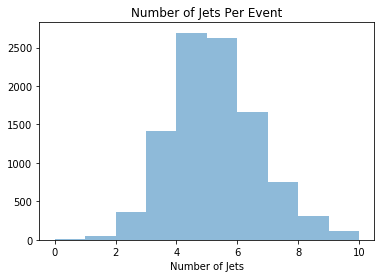

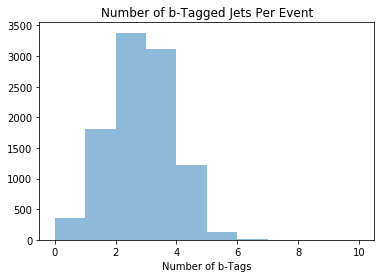

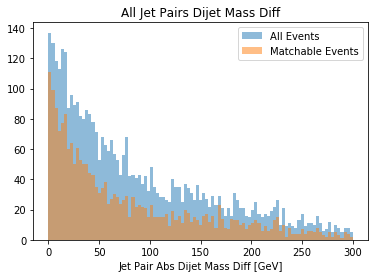

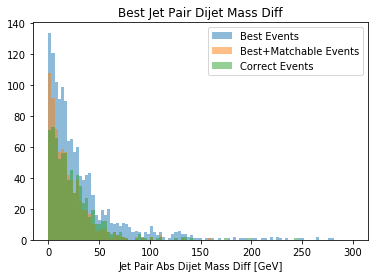

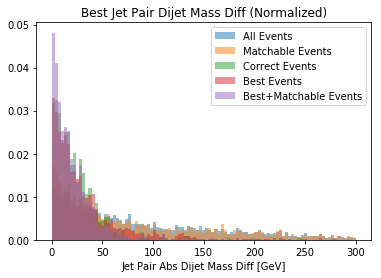

In [13]:
pairingAlgorithm = 'equalDijetMass'
plotOpts = [] # title, xtitle, xMin, xMax, nBins
if pairingAlgorithm == 'minHarmonicMeanDeltaR':
    plotOpts = ['Delta R', 'Delta R', 0, 5.0, 100]
elif pairingAlgorithm == 'closestDijetMassesToHiggs':
    plotOpts = ['Higgs Mass Diff', 'Higgs Mass Diff', 0, 50.0, 50]
elif pairingAlgorithm == 'equalDijetMass':
    plotOpts = ['Dijet Mass Diff', 'Abs Dijet Mass Diff [GeV]', -0.0, 300.0, 100]
elif pairingAlgorithm == 'equalDeltaR':
    plotOpts = ['Delta R', 'Delta R(h1, h2)', 0, 5.0, 100]
elif pairingAlgorithm == 'dijetMasses':
    plotOpts = ['Dijet Mass', 'Dijet Mass [GeV]', 0, 600.0, 100]
    
plotOneHistogram(nJetsPerEvent, 0, 'Number of Jets Per Event', 'Number of Jets', 0, 10, 11 )
plotOneHistogram(nBTagsPerEvent, 1, 'Number of b-Tagged Jets Per Event', 'Number of b-Tags', 0, 10, 11 )

compareManyHistograms( plottingData[pairingAlgorithm], ['All', 'Matchable'], 2, 'All Jet Pairs ' + plotOpts[0], 'Jet Pair ' + plotOpts[1], int(plotOpts[2]), int(plotOpts[3]), int(plotOpts[4]) )
compareManyHistograms( plottingData[pairingAlgorithm], ['Best', 'Best+Matchable', 'Correct'], 3, 'Best Jet Pair ' + plotOpts[0], 'Jet Pair ' + plotOpts[1], int(plotOpts[2]), int(plotOpts[3]), int(plotOpts[4]) )
compareManyHistograms( plottingData[pairingAlgorithm], ['All', 'Matchable', 'Correct', 'Best', 'Best+Matchable'], 5, 'Best Jet Pair ' + plotOpts[0], 'Jet Pair ' + plotOpts[1], int(plotOpts[2]), int(plotOpts[3]), int(plotOpts[4]), _normed=True)

# Look at higgs masss plots
#compareManyHistograms( plottingData['dijetMasses'], ['All', 'Matchable', 'Best', 'Best+Matchable'], 6, 'All Jet Pairs Di-Jet Mass', 'Jet Pair DiJet Mass [GeV]', 0, 500, 100 )
#compareManyHistograms( plottingData['dijetMasses'], ['All', 'Matchable'], 6, 'All Jet Pairs Di-Jet Mass', 'Jet Pair DiJet Mass [GeV]', 0, 500, 100 )
#compareManyHistograms( plottingData['dijetMasses'], ['Best', 'Best+Matchable','Correct'], 7, 'Best Jet Pair Di-Jet Mass', 'Jet Pair DiJet Mass [GeV]', 0, 500, 100 )


In [10]:
for algo in pairingAlgorithms:
    print(algo)
    printEventCounterInfo(eventCounterDict[algo], 'Incl')


minHarmonicMeanDeltaR
!!!! Event Counter Info For Incl
Number of Events: 8164
Number of Events with 4 truth-matchable jets: 3635
Number of Events Fully Matched: 1265
Number of Events with >= 1 Pair Matched: 2169
Efficiency For Fully Matched:  34.8 %
Efficiency For >= 1 Pair Matched:  59.67 %
closestDijetMassesToHiggs
!!!! Event Counter Info For Incl
Number of Events: 8164
Number of Events with 4 truth-matchable jets: 3635
Number of Events Fully Matched: 1702
Number of Events with >= 1 Pair Matched: 2468
Efficiency For Fully Matched:  46.82 %
Efficiency For >= 1 Pair Matched:  67.9 %
equalDijetMass
!!!! Event Counter Info For Incl
Number of Events: 8164
Number of Events with 4 truth-matchable jets: 3635
Number of Events Fully Matched: 1193
Number of Events with >= 1 Pair Matched: 1674
Efficiency For Fully Matched:  32.82 %
Efficiency For >= 1 Pair Matched:  46.05 %
equalDeltaR
!!!! Event Counter Info For Incl
Number of Events: 8164
Number of Events with 4 truth-matchable jets: 3635
Numb

In [59]:
import itertools
a=[1,2,3,4,5,6,7]
pairs = list(itertools.combinations(a,2))
#list(pairs)
pairPairs = {}
for two in pairs:
    notwo = [x for x in list(pairs) if two[0] not in x and two[1] not in x]
    for pairOption in notwo:
        sortedPairing = sorted([sorted(x) for x in [two, pairOption]])
        sortedTuple = tuple(sortedPairing[0]+sortedPairing[1])

        if sortedTuple not in pairPairs.keys():
            pairPairs[sortedTuple]=0

print(len(pairPairs))
print(pairPairs)
    

{'minHarmonicMeanDeltaR': {'Incl': 76.65, '4jIncl': 78.92, '4j4b': 78.92, '5jIncl': 77.02, '5j4b': 77.02, '6jIncl': 70.8, '6j4b': 70.8, '7jIncl': 71.43, '7j4b': 71.43}, 'closestDijetMassesToHiggs': {'Incl': 89.07, '4jIncl': 89.46, '4j4b': 89.46, '5jIncl': 88.09, '5j4b': 88.09, '6jIncl': 90.27, '6j4b': 90.27, '7jIncl': 88.1, '7j4b': 88.1}, 'equalDijetMass': {'Incl': 75.57, '4jIncl': 73.22, '4j4b': 73.22, '5jIncl': 75.74, '5j4b': 75.74, '6jIncl': 83.19, '6j4b': 83.19, '7jIncl': 73.81, '7j4b': 73.81}, 'equalDeltaR': {'Incl': 44.26, '4jIncl': 50.14, '4j4b': 50.14, '5jIncl': 41.7, '5j4b': 41.7, '6jIncl': 30.97, '6j4b': 30.97, '7jIncl': 45.24, '7j4b': 45.24}, 'dijetMasses': {'Incl': 83.0, '4jIncl': 86.04, '4j4b': 86.04, '5jIncl': 84.68, '5j4b': 84.68, '6jIncl': 76.99, '6j4b': 76.99, '7jIncl': 64.29, '7j4b': 64.29}}


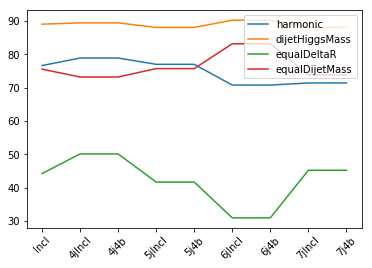

In [80]:
fullDict, oneDict = listOfEfficiencesForAlgorithm(eventCounterDict)
print (fullDict)
np.arange(19)
for algo in fullDict:
    labels_only4 = [tagEff for tagEff in fullDict[algo]]
    eff    = [fullDict[algo][tagEff] for tagEff in fullDict[algo]]
    #print (algo)
    #print (labels)
    #print (eff)

eff_harmonic_only4 = [fullDict['minHarmonicMeanDeltaR'][tagEff] for tagEff in fullDict['minHarmonicMeanDeltaR']]
eff_dijetHiggsMass_only4 = [fullDict['closestDijetMassesToHiggs'][tagEff] for tagEff in fullDict['closestDijetMassesToHiggs']]
eff_equalDeltaR_only4 = [fullDict['equalDeltaR'][tagEff] for tagEff in fullDict['equalDeltaR']]
eff_equalDijetMass_only4 = [fullDict['equalDijetMass'][tagEff] for tagEff in fullDict['equalDijetMass']]

xvals_only4 = np.arange(len(labels_only4))
y_harmonic_only4 = np.array(eff_harmonic_only4)
y_dijetHiggsMass_only4 = np.array(eff_dijetHiggsMass_only4)
y_equalDeltaR_only4 = np.array(eff_equalDeltaR_only4)
y_equalDijetMass_only4 = np.array(eff_equalDijetMass_only4)

plt.xticks(range(len(labels_only4)), labels_only4, rotation=45)
#plt.xticks(yvals1, alpha=t, normed=_normed, label= iLabel+' Events')
plt.plot(xvals_only4, y_harmonic_only4, label='harmonic')
plt.plot(xvals_only4, y_dijetHiggsMass_only4, label='dijetHiggsMass')
plt.plot(xvals_only4, y_equalDeltaR_only4, label='equalDeltaR')
plt.plot(xvals_only4, y_equalDijetMass_only4, label='equalDijetMass')

plt.legend(loc='upper right')

# store figure copy for later saving
fig = plt.gcf()
    
# draw interactively
plt.show()
    
fig.savefig( 'algoEfficiencyAsFtnOfJetTag_onlyBtags.png' )


{'minHarmonicMeanDeltaR': {'Incl': 71.15, '4jIncl': 77.37, '4j4b': 77.37, '5jIncl': 70.8, '5j4b': 74.47, '5j5b': 13.33, '6jIncl': 69.85, '6j4b': 77.71, '6j5b': 13.04, '6j6b': 0.0, '7jIncl': 65.25, '7j4b': 75.44, '7j5b': 23.81, '7j6b': 20.0, '7j7b': 0.0}, 'closestDijetMassesToHiggs': {'Incl': 86.41, '4jIncl': 87.89, '4j4b': 87.89, '5jIncl': 86.8, '5j4b': 89.36, '5j5b': 46.67, '6jIncl': 83.42, '6j4b': 87.43, '6j5b': 52.17, '6j6b': 100.0, '7jIncl': 87.94, '7j4b': 94.74, '7j5b': 71.43, '7j6b': 20.0, '7j7b': 0.0}, 'equalDijetMass': {'Incl': 70.9, '4jIncl': 71.05, '4j4b': 71.05, '5jIncl': 72.0, '5j4b': 74.89, '5j5b': 26.67, '6jIncl': 71.86, '6j4b': 80.0, '6j5b': 13.04, '6j6b': 0.0, '7jIncl': 67.38, '7j4b': 77.19, '7j5b': 33.33, '7j6b': 0.0, '7j7b': 0.0}, 'equalDeltaR': {'Incl': 41.92, '4jIncl': 53.16, '4j4b': 53.16, '5jIncl': 41.2, '5j4b': 43.83, '5j5b': 0.0, '6jIncl': 35.68, '6j4b': 37.71, '6j5b': 21.74, '6j6b': 0.0, '7jIncl': 36.88, '7j4b': 43.86, '7j5b': 9.52, '7j6b': 0.0, '7j7b': 0.0}, '

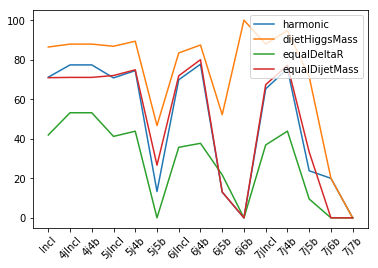

In [16]:
fullDict, oneDict = listOfEfficiencesForAlgorithm(eventCounterDict)
print (fullDict)
np.arange(19)
for algo in fullDict:
    labels_allB = [tagEff for tagEff in fullDict[algo]]
    eff    = [fullDict[algo][tagEff] for tagEff in fullDict[algo]]
    #print (algo)
    #print (labels)
    #print (eff)

eff_harmonic_allB = [fullDict['minHarmonicMeanDeltaR'][tagEff] for tagEff in fullDict['minHarmonicMeanDeltaR']]
eff_dijetHiggsMass_allB = [fullDict['closestDijetMassesToHiggs'][tagEff] for tagEff in fullDict['closestDijetMassesToHiggs']]
eff_equalDeltaR_allB = [fullDict['equalDeltaR'][tagEff] for tagEff in fullDict['equalDeltaR']]
eff_equalDijetMass_allB = [fullDict['equalDijetMass'][tagEff] for tagEff in fullDict['equalDijetMass']]

xvals_allB = np.arange(len(labels_allB))
y_harmonic_allB = np.array(eff_harmonic_allB)
y_dijetHiggsMass_allB = np.array(eff_dijetHiggsMass_allB)
y_equalDeltaR_allB = np.array(eff_equalDeltaR_allB)
y_equalDijetMass_allB = np.array(eff_equalDijetMass_allB)

plt.xticks(range(len(labels_allB)), labels_allB, rotation=45)
#plt.xticks(yvals1, alpha=t, normed=_normed, label= iLabel+' Events')
plt.plot(xvals_allB, y_harmonic_allB, label='harmonic')
plt.plot(xvals_allB, y_dijetHiggsMass_allB, label='dijetHiggsMass')
plt.plot(xvals_allB, y_equalDeltaR_allB, label='equalDeltaR')
plt.plot(xvals_allB, y_equalDijetMass_allB, label='equalDijetMass')

plt.legend(loc='upper right')

# store figure copy for later saving
fig = plt.gcf()
    
# draw interactively
plt.show()
    
fig.savefig( 'algoEfficiencyAsFtnOfJetTag_allBtags.png' )

{'minHarmonicMeanDeltaR': {'Incl': 76.65, '4jIncl': 77.37, '4j4b': 77.37, '5jIncl': 74.9, '5j4b': 74.47, '5j5b': 87.5, '6jIncl': 78.8, '6j4b': 77.71, '6j5b': 100.0, '7jIncl': 75.81, '7j4b': 75.44, '7j5b': 80.0}, 'closestDijetMassesToHiggs': {'Incl': 89.07, '4jIncl': 87.89, '4j4b': 87.89, '5jIncl': 88.48, '5j4b': 89.36, '5j5b': 62.5, '6jIncl': 87.5, '6j4b': 87.43, '6j5b': 88.89, '7jIncl': 94.35, '7j4b': 94.74, '7j5b': 90.0}, 'equalDijetMass': {'Incl': 75.57, '4jIncl': 71.05, '4j4b': 71.05, '5jIncl': 74.9, '5j4b': 74.89, '5j5b': 75.0, '6jIncl': 79.89, '6j4b': 80.0, '6j5b': 77.78, '7jIncl': 77.42, '7j4b': 77.19, '7j5b': 80.0}, 'equalDeltaR': {'Incl': 44.26, '4jIncl': 53.16, '4j4b': 53.16, '5jIncl': 43.21, '5j4b': 43.83, '5j5b': 25.0, '6jIncl': 37.5, '6j4b': 37.71, '6j5b': 33.33, '7jIncl': 42.74, '7j4b': 43.86, '7j5b': 30.0}, 'dijetMasses': {'Incl': 83.0, '4jIncl': 86.32, '4j4b': 86.32, '5jIncl': 83.13, '5j4b': 82.98, '5j5b': 87.5, '6jIncl': 83.15, '6j4b': 82.29, '6j5b': 100.0, '7jIncl': 7

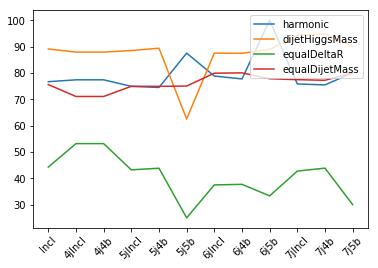

In [10]:
fullDict, oneDict = listOfEfficiencesForAlgorithm(eventCounterDict)
print (fullDict)
np.arange(19)
for algo in fullDict:
    labels_top4 = [tagEff for tagEff in fullDict[algo]]
    eff    = [fullDict[algo][tagEff] for tagEff in fullDict[algo]]
    #print (algo)
    #print (labels)
    #print (eff)

eff_harmonic_top4 = [fullDict['minHarmonicMeanDeltaR'][tagEff] for tagEff in fullDict['minHarmonicMeanDeltaR']]
eff_dijetHiggsMass_top4 = [fullDict['closestDijetMassesToHiggs'][tagEff] for tagEff in fullDict['closestDijetMassesToHiggs']]
eff_equalDeltaR_top4 = [fullDict['equalDeltaR'][tagEff] for tagEff in fullDict['equalDeltaR']]
eff_equalDijetMass_top4 = [fullDict['equalDijetMass'][tagEff] for tagEff in fullDict['equalDijetMass']]

xvals_top4 = np.arange(len(labels_top4))
y_harmonic_top4 = np.array(eff_harmonic_top4)
y_dijetHiggsMass_top4 = np.array(eff_dijetHiggsMass_top4)
y_equalDeltaR_top4 = np.array(eff_equalDeltaR_top4)
y_equalDijetMass_top4 = np.array(eff_equalDijetMass_top4)

plt.xticks(range(len(labels_top4)), labels_top4, rotation=45)
#plt.xticks(yvals1, alpha=t, normed=_normed, label= iLabel+' Events')
plt.plot(xvals_top4, y_harmonic_top4, label='harmonic')
plt.plot(xvals_top4, y_dijetHiggsMass_top4, label='dijetHiggsMass')
plt.plot(xvals_top4, y_equalDeltaR_top4, label='equalDeltaR')
plt.plot(xvals_top4, y_equalDijetMass_top4, label='equalDijetMass')

plt.legend(loc='upper right')

# store figure copy for later saving
fig = plt.gcf()
    
# draw interactively
plt.show()
    
fig.savefig( 'algoEfficiencyAsFtnOfJetTag_top4Btags.png' )


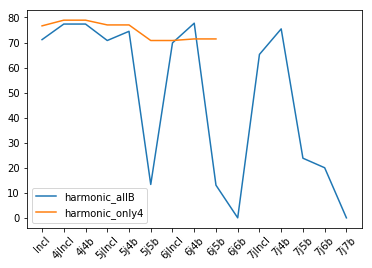

In [90]:
plt.xticks(range(len(labels_allB)), labels_allB, rotation=45)
#plt.xticks(yvals1, alpha=t, normed=_normed, label= iLabel+' Events')
plt.plot(xvals_allB, y_harmonic_allB, label='harmonic_allB')
plt.plot(xvals_only4, y_harmonic_only4, label='harmonic_only4')

plt.legend(loc='lower left')

plt.show()